# Multi-Seed Experiments for Statistical Significance

This notebook runs key experiments with explicit random seeds to compute mean ± std.

## Setup
1. **Computer 1**: Set `COMPUTER = 1` → runs seed 42 (4 experiments, ~4 hrs)
2. **Computer 2**: Set `COMPUTER = 2` → runs seed 43 + extra seed 44 (5 experiments, ~5 hrs)

## Experiments
| Experiment | α | γ | Description |
|------------|---|---|-------------|
| baseline_agrekd | 1.0 | 0.0 | AGRE-KD baseline |
| exp2_gamma025 | 1.0 | 0.25 | Feature distillation (best from initial runs) |
| aver_baseline | 1.0 | 0.0 | Simple averaging (no AGRE weighting) |
| exp3_a09_g025 | 0.9 | 0.25 | Combined: some class labels + feature distillation |

---
## 1. Setup Environment

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install dependencies
!pip install -q wilds tqdm scikit-learn

# Verify GPU
import torch
print(f"\n{'='*50}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"{'='*50}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
Memory: 15.8 GB


In [ ]:
import os
import sys
import json
import random
import numpy as np

# ============================================================
# CONFIGURE YOUR PATHS HERE
# ============================================================
GITHUB_REPO = 'dat-tran05/robust-ensemble-kd'
DRIVE_ROOT = '/content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd'

# Derived paths
CODE_DIR = '/content/repo'
DATA_DIR = f'{DRIVE_ROOT}/data/waterbirds_v1.0'
TEACHER_DIR = f'{DRIVE_ROOT}/teacher_checkpoints'
CHECKPOINT_DIR = f'{DRIVE_ROOT}/checkpoints'
LOG_DIR = f'{DRIVE_ROOT}/logs'

# Create directories
for d in [TEACHER_DIR, CHECKPOINT_DIR, LOG_DIR]:
    os.makedirs(d, exist_ok=True)

print(f"Drive root: {DRIVE_ROOT}")
print(f"Checkpoints: {CHECKPOINT_DIR}")
print(f"Logs: {LOG_DIR}")

Drive root: /content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd
Checkpoints: /content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd/checkpoints
Logs: /content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd/logs


In [ ]:
# Clone or update repository
if os.path.exists(CODE_DIR):
    print("Repository exists, pulling latest...")
    %cd {CODE_DIR}
    !git pull
else:
    print("Cloning repository...")
    !git clone https://github.com/{GITHUB_REPO}.git {CODE_DIR}
    %cd {CODE_DIR}

# Navigate to light-code directory
%cd {CODE_DIR}/light-code

# Add to Python path
sys.path.insert(0, f'{CODE_DIR}/light-code')

# Verify imports work
try:
    from data import get_waterbirds_loaders
    from models import get_teacher_model, get_student_model, load_teacher_checkpoint
    from losses import AGREKDLoss
    from eval import compute_group_accuracies, print_results
    from config import Config
    from train import train_student
    print("\n All imports successful!")
except ImportError as e:
    print(f"Import error: {e}")

Cloning repository...
Cloning into '/content/repo'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 76 (delta 41), reused 58 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 82.57 KiB | 7.51 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/repo
/content/repo/light-code

 All imports successful!


---
## 2. Computer Configuration

**IMPORTANT**: Change `COMPUTER` to 1 or 2 depending on which machine you're running!

In [ ]:
# ============================================================
# CONFIGURE: Which computer is this?
# ============================================================
COMPUTER = 2  # <-- CHANGE THIS: Set to 1 or 2

# ============================================================
# Experiment definitions (name, alpha, gamma, use_agre)
# ============================================================
EXPERIMENTS = [
    ('baseline_agrekd', 1.0, 0.0, True),   # AGRE-KD baseline
    ('exp2_gamma025', 1.0, 0.25, True),    # Feature distillation (best)
    ('aver_baseline', 1.0, 0.0, False),    # Simple averaging
    ('exp3_a09_g025', 0.9, 0.25, True),    # Combined (NEW)
]

# Set seeds based on computer
if COMPUTER == 1:
    SEEDS = [42]
    EXTRA_RUNS = []  # No extra runs for Computer 1
    print("COMPUTER 1: Running seed 42")
    print(f"  - {len(EXPERIMENTS)} experiments x 1 seed = {len(EXPERIMENTS)} runs")
    print(f"  - Estimated time: ~4 hours")
elif COMPUTER == 2:
    SEEDS = [43]
    # Extra seed 44 for exp3_a09_g025 to get 3 seeds total
    EXTRA_RUNS = [('exp3_a09_g025', 0.9, 0.25, True, 44)]
    print("COMPUTER 2: Running seed 43 + extra seed 44")
    print(f"  - {len(EXPERIMENTS)} experiments x 1 seed = {len(EXPERIMENTS)} runs")
    print(f"  - Plus 1 extra run (exp3_a09_g025 with seed 44)")
    print(f"  - Total: {len(EXPERIMENTS) + len(EXTRA_RUNS)} runs")
    print(f"  - Estimated time: ~5 hours")
else:
    raise ValueError("COMPUTER must be 1 or 2!")

print("\nExperiments to run:")
for name, alpha, gamma, use_agre in EXPERIMENTS:
    for seed in SEEDS:
        print(f"  - {name}_seed{seed} (α={alpha}, γ={gamma}, AGRE={use_agre})")
for name, alpha, gamma, use_agre, seed in EXTRA_RUNS:
    print(f"  - {name}_seed{seed} (α={alpha}, γ={gamma}, AGRE={use_agre}) [EXTRA]")

COMPUTER 2: Running seed 43 + extra seed 44
  - 4 experiments x 1 seed = 4 runs
  - Plus 1 extra run (exp3_a09_g025 with seed 44)
  - Total: 5 runs
  - Estimated time: ~5 hours

Experiments to run:
  - baseline_agrekd_seed43 (α=1.0, γ=0.0, AGRE=True)
  - exp2_gamma025_seed43 (α=1.0, γ=0.25, AGRE=True)
  - aver_baseline_seed43 (α=1.0, γ=0.0, AGRE=False)
  - exp3_a09_g025_seed43 (α=0.9, γ=0.25, AGRE=True)
  - exp3_a09_g025_seed44 (α=0.9, γ=0.25, AGRE=True) [EXTRA]


---
## 3. Seed Setting Function

In [ ]:
def set_seed(seed):
    """
    Set all random seeds for reproducibility.

    This ensures:
    - Same FC layer initialization (only layer not from ImageNet)
    - Same batch ordering during training
    - Same dropout patterns (if any)
    - Deterministic CUDA operations
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    # For deterministic behavior (slightly slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"  Set random seed: {seed}")

print("Seed function defined!")

Seed function defined!


---
## 4. Load Teachers

In [ ]:
import glob

# Debiased teachers (for distillation)
debiased_paths = sorted(glob.glob(f'{TEACHER_DIR}/teacher_*_debiased.pt'))
print(f"Loading {len(debiased_paths)} debiased teachers...")

teachers = []
for path in debiased_paths:
    model = get_teacher_model('resnet50', num_classes=2, pretrained=False)
    load_teacher_checkpoint(model, path)
    model.cuda().eval()
    teachers.append(model)

    # Get WGA from checkpoint for logging
    ckpt = torch.load(path, map_location='cpu')
    wga = ckpt.get('wga', 0.0)
    print(f"  {os.path.basename(path)} (WGA: {wga*100:.1f}%)")

print(f"\nLoaded {len(teachers)} debiased teachers!")

# Biased teacher (for AGRE-KD reference)
erm_paths = sorted(glob.glob(f'{TEACHER_DIR}/erm_seed*.pt'))
if erm_paths:
    biased_model = get_teacher_model('resnet50', num_classes=2, pretrained=False)
    load_teacher_checkpoint(biased_model, erm_paths[0])
    biased_model.cuda().eval()
    print(f"\nLoaded biased reference: {os.path.basename(erm_paths[0])}")
else:
    print("\nNo ERM checkpoint found!")
    biased_model = None

print(f"\nReady for experiments!")

Loading 5 debiased teachers...
Loaded checkpoint from /content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd/teacher_checkpoints/teacher_1_debiased.pt
  All keys matched!
  teacher_1_debiased.pt (WGA: 93.3%)
Loaded checkpoint from /content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd/teacher_checkpoints/teacher_2_debiased.pt
  All keys matched!
  teacher_2_debiased.pt (WGA: 92.1%)
Loaded checkpoint from /content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd/teacher_checkpoints/teacher_3_debiased.pt
  All keys matched!
  teacher_3_debiased.pt (WGA: 91.9%)
Loaded checkpoint from /content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd/teacher_checkpoints/teacher_4_debiased.pt
  All keys matched!
  teacher_4_debiased.pt (WGA: 93.6%)
Loaded checkpoint

---
## 5. Experiment Runner with Seed

In [ ]:
def run_experiment_with_seed(exp_name, alpha, gamma, seed, use_agre=True):
    """
    Run a single experiment with explicit seed setting.

    Args:
        exp_name: Base experiment name
        alpha: Weight for KD vs CE loss
        gamma: Weight for feature distillation
        seed: Random seed for reproducibility
        use_agre: If True, use gradient-based weighting

    Returns:
        test_results: Dict with WGA, avg_acc, group_accs
    """
    # Create full experiment name with seed
    full_exp_name = f"{exp_name}_seed{seed}"

    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {full_exp_name}")
    print(f"  α={alpha}, γ={gamma}, AGRE={use_agre}, seed={seed}")
    print(f"{'='*60}\n")

    # Check if already completed
    results_path = os.path.join(CHECKPOINT_DIR, f'student_{full_exp_name}_results.pt')
    if os.path.exists(results_path):
        print(f"Experiment already completed! Loading cached results...")
        results = torch.load(results_path)
        print_results(results['test_results'], f"{full_exp_name} (cached)")
        return results['test_results']

    # SET SEED BEFORE ANYTHING ELSE
    set_seed(seed)

    # Check for resume checkpoint
    resume_path = os.path.join(CHECKPOINT_DIR, f'student_{full_exp_name}_latest.pt')
    if os.path.exists(resume_path):
        print(f"Found checkpoint, will resume training...")
    else:
        resume_path = None

    # Create config
    config = Config(
        data_dir=DATA_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        alpha=alpha,
        gamma=gamma,
        epochs=30,
        lr=0.001,
        batch_size=128,
        temperature=4.0,
        seed=seed,  # Pass seed to config
    )

    # Train student
    student, history, test_results = train_student(
        config=config,
        teachers=teachers,
        biased_model=biased_model,
        exp_name=full_exp_name,
        use_agre=use_agre,
        checkpoint_path=resume_path,
    )

    # Log results to JSON
    log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            all_logs = json.load(f)
    else:
        all_logs = {}

    all_logs[full_exp_name] = {
        'base_exp': exp_name,
        'seed': seed,
        'alpha': alpha,
        'gamma': gamma,
        'use_agre': use_agre,
        'wga': test_results['wga'],
        'avg_acc': test_results['avg_acc'],
        'group_accs': {str(k): v for k, v in test_results['group_accs'].items()},
    }

    with open(log_path, 'w') as f:
        json.dump(all_logs, f, indent=2)

    return test_results

print("Experiment runner ready!")
print(f"Results will be saved to: {LOG_DIR}/seed_experiment_results.json")

Experiment runner ready!
Results will be saved to: /content/drive/MyDrive/MIT/MIT Junior Year (2025-2026)/Fall Semester/6.7960/6.7960 Final Project/robust-ensemble-kd/logs/seed_experiment_results.json


---
## 6. Run All Experiments

This cell runs all experiments for the configured computer. Each takes ~1 hour.

In [ ]:
# Run all experiments for this computer
all_results = {}

print(f"Starting experiments for Computer {COMPUTER}...")
print(f"Total runs: {len(EXPERIMENTS) * len(SEEDS) + len(EXTRA_RUNS)}\n")

# Main experiments
for exp_name, alpha, gamma, use_agre in EXPERIMENTS:
    for seed in SEEDS:
        full_name = f"{exp_name}_seed{seed}"
        result = run_experiment_with_seed(exp_name, alpha, gamma, seed, use_agre)
        all_results[full_name] = result

# Extra runs (only for Computer 2)
for exp_name, alpha, gamma, use_agre, seed in EXTRA_RUNS:
    full_name = f"{exp_name}_seed{seed}"
    result = run_experiment_with_seed(exp_name, alpha, gamma, seed, use_agre)
    all_results[full_name] = result

print("\n" + "="*60)
print("ALL EXPERIMENTS COMPLETE!")
print("="*60)

Starting experiments for Computer 2...
Total runs: 5


EXPERIMENT: baseline_agrekd_seed43
  α=1.0, γ=0.0, AGRE=True, seed=43

Experiment already completed! Loading cached results...

 baseline_agrekd_seed43 (cached)

Per-group accuracy:
  Landbird + Land (majority): 96.98% (n=2255)
  Landbird + Water (minority): 87.36% (n=2255)
  Waterbird + Land (minority, hardest): 85.67% (n=642)
  Waterbird + Water (majority): 93.61% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 85.67%
  Average Accuracy: 91.61%
  Accuracy Gap: 11.31%
  Worst Group: 2


EXPERIMENT: exp2_gamma025_seed43
  α=1.0, γ=0.25, AGRE=True, seed=43

Experiment already completed! Loading cached results...

 exp2_gamma025_seed43 (cached)

Per-group accuracy:
  Landbird + Land (majority): 97.69% (n=2255)
  Landbird + Water (minority): 88.60% (n=2255)
  Waterbird + Land (minority, hardest): 85.67% (n=642)
  Waterbird + Water (majority): 93.77% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 85.67%
  Average A

---
## 7. Results Summary

In [ ]:
import pandas as pd

# Load results
log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')

if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        results = json.load(f)

    # Create summary table
    rows = []
    for exp_name, data in results.items():
        rows.append({
            'Experiment': exp_name,
            'Base': data.get('base_exp', exp_name.rsplit('_seed', 1)[0]),
            'Seed': data.get('seed', 'N/A'),
            'α': data['alpha'],
            'γ': data['gamma'],
            'WGA (%)': round(data['wga'] * 100, 2),
            'Avg Acc (%)': round(data['avg_acc'] * 100, 2),
        })

    df = pd.DataFrame(rows)
    df = df.sort_values(['Base', 'Seed'])

    print("\n" + "="*70)
    print("SEED EXPERIMENT RESULTS")
    print("="*70)
    print(df.to_string(index=False))
    print("="*70)

    # Group by base experiment and compute mean/std
    print("\n" + "="*70)
    print("AGGREGATED RESULTS (Mean ± Std)")
    print("="*70)

    for base_exp in df['Base'].unique():
        subset = df[df['Base'] == base_exp]
        wga_mean = subset['WGA (%)'].mean()
        wga_std = subset['WGA (%)'].std()
        n_seeds = len(subset)
        print(f"{base_exp}: {wga_mean:.2f} ± {wga_std:.2f}% (n={n_seeds})")

    print("="*70)
else:
    print("No results found yet. Run experiments first!")


SEED EXPERIMENT RESULTS
            Experiment            Base  Seed   α    γ  WGA (%)  Avg Acc (%)
  aver_baseline_seed42   aver_baseline    42 1.0 0.00    84.42        92.87
  aver_baseline_seed43   aver_baseline    43 1.0 0.00    85.05        91.75
  aver_gamma025_seed42   aver_gamma025    42 1.0 0.25    84.42        92.23
 aver_gamma_050_seed42  aver_gamma_050    42 1.0 0.50    84.89        92.66
 aver_gamma_100_seed42  aver_gamma_100    42 1.0 1.00    84.27        92.82
baseline_agrekd_seed42 baseline_agrekd    42 1.0 0.00    84.58        92.79
baseline_agrekd_seed43 baseline_agrekd    43 1.0 0.00    85.67        91.61
baseline_agrekd_seed44 baseline_agrekd    44 1.0 0.00    83.18        92.47
disagree_weight_seed42 disagree_weight    42 1.0 0.50    84.89        92.68
  exp2_gamma025_seed42   exp2_gamma025    42 1.0 0.25    84.11        92.22
  exp2_gamma025_seed43   exp2_gamma025    43 1.0 0.25    85.67        92.39
  exp2_gamma025_seed44   exp2_gamma025    44 1.0 0.25    84.74 

---
## 8. Combine with Original Results

After both computers finish, run this cell to combine all results including the original (seed 1) runs.

In [ ]:
# Original results from first runs (no seed was set - unreproducible)
# Treating as one independent run for mean ± std calculation
ORIGINAL_RESULTS = {
    'baseline_agrekd': {'wga': 85.05, 'avg_acc': 91.42},
    'exp2_gamma025': {'wga': 86.29, 'avg_acc': 92.96},
    'aver_baseline': {'wga': 83.33, 'avg_acc': 92.79},
    # exp3_a09_g025 is NEW - no original result
}

# Load seed experiment results
log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')

if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        seed_results = json.load(f)

    print("="*70)
    print("FINAL COMBINED RESULTS (Original + Seeds 42, 43)")
    print("="*70)

    # Combine results
    combined = {}

    for base_exp in ['baseline_agrekd', 'exp2_gamma025', 'aver_baseline', 'exp3_a09_g025']:
        wgas = []

        # Add original if exists
        if base_exp in ORIGINAL_RESULTS:
            wgas.append(ORIGINAL_RESULTS[base_exp]['wga'])

        # Add seed results
        for seed in [42, 43, 44]:
            key = f"{base_exp}_seed{seed}"
            if key in seed_results:
                wgas.append(seed_results[key]['wga'] * 100)

        if wgas:
            combined[base_exp] = wgas
            mean = np.mean(wgas)
            std = np.std(wgas) if len(wgas) > 1 else 0
            print(f"{base_exp}:")
            print(f"  Seeds: {wgas}")
            print(f"  Result: {mean:.2f} ± {std:.2f}% (n={len(wgas)})")
            print()

    print("="*70)
else:
    print("No seed results found. Run experiments first!")

FINAL COMBINED RESULTS (Original + Seeds 42, 43)
baseline_agrekd:
  Seeds: [85.05, 84.57943925233646, 85.66978193146417, 83.17757009345794]
  Result: 84.62 ± 0.92% (n=4)

exp2_gamma025:
  Seeds: [86.29, 84.11214953271028, 85.66978193146417, 84.73520249221184]
  Result: 85.20 ± 0.84% (n=4)

aver_baseline:
  Seeds: [83.33, 84.42367601246106, 85.04672897196261]
  Result: 84.27 ± 0.71% (n=3)

exp3_a09_g025:
  Seeds: [83.17757009345794, 85.202492211838, 84.11214953271028]
  Result: 84.16 ± 0.83% (n=3)



---
## Notes

After both computers complete:

1. **Computer 1** will have: `*_seed42` results
2. **Computer 2** will have: `*_seed43` results + `exp3_a09_g025_seed44`

The results are saved to the same Google Drive location, so the `seed_experiment_results.json` file will contain all results.

### Expected Final Table

| Experiment | Seed 1 | Seed 42 | Seed 43 | Mean ± Std |
|------------|--------|---------|---------|------------|
| AVER | 83.33% | ? | ? | ? |
| AGRE-KD (baseline) | 85.05% | ? | ? | ? |
| AGRE-KD + FeatDist | 86.29% | ? | ? | ? |
| AGRE-KD + Combined | - | ? | ? (+s44) | ? |

---
## 9. Gamma Ablation & AVER Experiments

This section runs additional experiments for the gamma sensitivity curve and AVER baseline comparison.

### Experiments
| Experiment | α | γ | use_agre | Purpose |
|------------|---|---|----------|---------|
| gamma_005 | 1.0 | 0.05 | True | Gamma sensitivity (weak) |
| gamma_050 | 1.0 | 0.50 | True | Gamma sensitivity (strong) |
| gamma_075 | 1.0 | 0.75 | True | Gamma sensitivity (very strong) |
| gamma_100 | 1.0 | 1.00 | True | Gamma sensitivity (equal weight) |
| aver_gamma025 | 1.0 | 0.25 | False | AVER + feature distillation |

### Computer Assignment
- **Computer 1**: gamma_075, gamma_100 (+ exp3 seeds from above)
- **Computer 2**: gamma_005, gamma_050, aver_gamma025

In [ ]:
# ============================================================
# Gamma Ablation Experiments Configuration
# ============================================================

# All gamma ablation experiments (name, alpha, gamma, use_agre)
GAMMA_ABLATION_EXPERIMENTS = [
    ('gamma_005', 1.0, 0.05, True),      # Weak feature distillation
    ('gamma_050', 1.0, 0.50, True),      # Strong feature distillation
    ('gamma_075', 1.0, 0.75, True),      # Very strong feature distillation
    ('gamma_100', 1.0, 1.00, True),      # Equal weight (KD = feature)
    ('aver_gamma025', 1.0, 0.25, False), # AVER + feature (no AGRE weighting)
]

# Computer assignment for ablation experiments
if COMPUTER == 2:
    ABLATION_RUNS = [
        ('gamma_075', 1.0, 0.75, True, 42),
        ('gamma_100', 1.0, 1.00, True, 42),
    ]
    print("COMPUTER 2 Ablation Experiments:")
    print("  - gamma_075 (γ=0.75, seed 42)")
    print("  - gamma_100 (γ=1.00, seed 42)")
elif COMPUTER == 1:
    ABLATION_RUNS = [
        ('gamma_005', 1.0, 0.05, True, 42),
        ('gamma_050', 1.0, 0.50, True, 42),
        ('aver_gamma025', 1.0, 0.25, False, 42),
    ]
    print("COMPUTER 1 Ablation Experiments:")
    print("  - gamma_005 (γ=0.05, seed 42)")
    print("  - gamma_050 (γ=0.50, seed 42)")
    print("  - aver_gamma025 (γ=0.25, AVER, seed 42)")

print(f"\nTotal ablation runs: {len(ABLATION_RUNS)}")
print(f"Estimated time: ~{len(ABLATION_RUNS)} hours")

COMPUTER 2 Ablation Experiments:
  - gamma_075 (γ=0.75, seed 42)
  - gamma_100 (γ=1.00, seed 42)

Total ablation runs: 2
Estimated time: ~2 hours


In [ ]:
# ============================================================
# Run Gamma Ablation Experiments
# ============================================================
ablation_results = {}

print(f"Starting Gamma Ablation Experiments for Computer {COMPUTER}...")
print(f"Total ablation runs: {len(ABLATION_RUNS)}\n")

for exp_name, alpha, gamma, use_agre, seed in ABLATION_RUNS:
    full_name = f"{exp_name}_seed{seed}"
    result = run_experiment_with_seed(exp_name, alpha, gamma, seed, use_agre)
    ablation_results[full_name] = result

print("\n" + "="*60)
print("GAMMA ABLATION EXPERIMENTS COMPLETE!")
print("="*60)

Starting Gamma Ablation Experiments for Computer 2...
Total ablation runs: 2


EXPERIMENT: gamma_075_seed42
  α=1.0, γ=0.75, AGRE=True, seed=42

Experiment already completed! Loading cached results...

 gamma_075_seed42 (cached)

Per-group accuracy:
  Landbird + Land (majority): 97.92% (n=2255)
  Landbird + Water (minority): 89.05% (n=2255)
  Waterbird + Land (minority, hardest): 84.42% (n=642)
  Waterbird + Water (majority): 92.83% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 84.42%
  Average Accuracy: 92.41%
  Accuracy Gap: 13.49%
  Worst Group: 2


EXPERIMENT: gamma_100_seed42
  α=1.0, γ=1.0, AGRE=True, seed=42

Experiment already completed! Loading cached results...

 gamma_100_seed42 (cached)

Per-group accuracy:
  Landbird + Land (majority): 98.05% (n=2255)
  Landbird + Water (minority): 90.73% (n=2255)
  Waterbird + Land (minority, hardest): 85.36% (n=642)
  Waterbird + Water (majority): 92.37% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 85.36%
  Avera

In [ ]:
# ============================================================
# Gamma Ablation Results Summary
# ============================================================

# Load all results including gamma ablation
log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')

if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        all_results = json.load(f)

    print("="*70)
    print("GAMMA SENSITIVITY CURVE")
    print("="*70)

    # Gamma values to check (including baseline)
    gamma_experiments = [
        ('baseline_agrekd', 0.0),  # γ=0 baseline
        ('gamma_005', 0.05),
        ('exp2_gamma025', 0.25),   # From main experiments
        ('gamma_050', 0.50),
        ('gamma_075', 0.75),
        ('gamma_100', 1.00),
    ]

    print(f"\n{'γ':<8} {'WGA (%)':<12} {'Experiment'}")
    print("-" * 40)

    for exp_name, gamma in gamma_experiments:
        # Look for seed 42 result
        key = f"{exp_name}_seed42"
        if key in all_results:
            wga = all_results[key]['wga'] * 100
            print(f"{gamma:<8} {wga:<12.2f} {exp_name}")
        else:
            print(f"{gamma:<8} {'N/A':<12} {exp_name} (not found)")

    print("\n" + "="*70)
    print("AVER vs AGRE-KD with Feature Distillation (γ=0.25)")
    print("="*70)

    # Compare AVER vs AGRE with γ=0.25
    comparisons = [
        ('exp2_gamma025', 'AGRE-KD + γ=0.25'),
        ('aver_gamma025', 'AVER + γ=0.25'),
    ]

    for exp_name, label in comparisons:
        key = f"{exp_name}_seed42"
        if key in all_results:
            wga = all_results[key]['wga'] * 100
            print(f"{label}: {wga:.2f}%")
        else:
            print(f"{label}: N/A (not found)")

    print("="*70)
else:
    print("No results found. Run experiments first!")

GAMMA SENSITIVITY CURVE

γ        WGA (%)      Experiment
----------------------------------------
0.0      84.58        baseline_agrekd
0.05     83.96        gamma_005
0.25     84.11        exp2_gamma025
0.5      85.36        gamma_050
0.75     84.42        gamma_075
1.0      85.36        gamma_100

AVER vs AGRE-KD with Feature Distillation (γ=0.25)
AGRE-KD + γ=0.25: 84.11%
AVER + γ=0.25: 84.42%


---
## 10. AVER + High Gamma & Multi-Layer Experiments

### New Experiments (Priority from TA)

| Experiment | α | γ | use_agre | layer_gammas | Purpose |
|------------|---|---|----------|--------------|---------|
| aver_gamma_050 | 1.0 | 0.5 | False | None | AVER + strong feature distillation |
| aver_gamma_100 | 1.0 | 1.0 | False | None | AVER + equal weight feature distillation |
| ml_L3_L4 | 1.0 | - | True | {layer3: 0.15, layer4: 0.35} | Multi-layer (total γ=0.5) |
| ml_L2_L3_L4 | 1.0 | - | True | {layer2: 0.1, layer3: 0.15, layer4: 0.25} | Three-layer (total γ=0.5) |

### Computer Assignment
| Computer | AVER Experiment | Multi-Layer Experiment | Total Time |
|----------|-----------------|------------------------|------------|
| **Computer 1** | aver_gamma_050 (γ=0.5) | ml_L3_L4 | ~2 hours |
| **Computer 2** | aver_gamma_100 (γ=1.0) | ml_L2_L3_L4 | ~2 hours |

**Note**: Multi-layer experiments require the updated `losses.py` and `train.py` with `MultiLayerFeatureDistillationLoss`. Make sure to `git pull` before running!

In [ ]:
# ============================================================
# AVER + High Gamma & Multi-Layer Experiments Configuration
# ============================================================
# Split between computers like earlier experiments

if COMPUTER == 1:
    # Computer 1: AVER γ=0.5 + Multi-layer L3+L4
    AVER_HIGH_GAMMA_EXPERIMENTS = [
        ('aver_gamma_050', 1.0, 0.5, False, 42),   # AVER + γ=0.5
    ]
    MULTILAYER_EXPERIMENTS = [
        ('ml_L3_L4', {'layer3': 0.15, 'layer4': 0.35}, 42, True),  # Two layers, total γ=0.5
    ]
    print("COMPUTER 1 - New Experiments:")
    print("  AVER:")
    print("    - aver_gamma_050 (γ=0.5, AVER, seed 42)")
    print("  Multi-Layer:")
    print("    - ml_L3_L4 (layer3=0.15, layer4=0.35, total γ=0.5, seed 42)")
    print(f"\n  Total: 2 experiments (~2 hours)")

elif COMPUTER == 2:
    # Computer 2: AVER γ=1.0 + Multi-layer L2+L3+L4
    AVER_HIGH_GAMMA_EXPERIMENTS = [
        ('aver_gamma_100', 1.0, 1.0, False, 42),   # AVER + γ=1.0
    ]
    MULTILAYER_EXPERIMENTS = [
        ('ml_L2_L3_L4', {'layer2': 0.1, 'layer3': 0.15, 'layer4': 0.25}, 42, True),  # Three layers, total γ=0.5
    ]
    print("COMPUTER 2 - New Experiments:")
    print("  AVER:")
    print("    - aver_gamma_100 (γ=1.0, AVER, seed 42)")
    print("  Multi-Layer:")
    print("    - ml_L2_L3_L4 (layer2=0.1, layer3=0.15, layer4=0.25, total γ=0.5, seed 42)")
    print(f"\n  Total: 2 experiments (~2 hours)")

print("\n" + "="*50)
print("EXPERIMENT ASSIGNMENT SUMMARY")
print("="*50)
print("Computer 1: aver_gamma_050, ml_L3_L4")
print("Computer 2: aver_gamma_100, ml_L2_L3_L4")
print("="*50)

COMPUTER 2 - New Experiments:
  AVER:
    - aver_gamma_100 (γ=1.0, AVER, seed 42)
  Multi-Layer:
    - ml_L2_L3_L4 (layer2=0.1, layer3=0.15, layer4=0.25, total γ=0.5, seed 42)

  Total: 2 experiments (~2 hours)

EXPERIMENT ASSIGNMENT SUMMARY
Computer 1: aver_gamma_050, ml_L3_L4
Computer 2: aver_gamma_100, ml_L2_L3_L4


In [ ]:
# ============================================================
# Run AVER + High Gamma Experiments (for this computer)
# ============================================================
aver_high_gamma_results = {}

print(f"Starting AVER + High Gamma Experiments for Computer {COMPUTER}...")
print(f"Total AVER runs: {len(AVER_HIGH_GAMMA_EXPERIMENTS)}\n")

for exp_name, alpha, gamma, use_agre, seed in AVER_HIGH_GAMMA_EXPERIMENTS:
    full_name = f"{exp_name}_seed{seed}"
    result = run_experiment_with_seed(exp_name, alpha, gamma, seed, use_agre)
    aver_high_gamma_results[full_name] = result

print("\n" + "="*60)
print("AVER + HIGH GAMMA EXPERIMENTS COMPLETE!")
print("="*60)

Starting AVER + High Gamma Experiments for Computer 2...
Total AVER runs: 1


EXPERIMENT: aver_gamma_100_seed42
  α=1.0, γ=1.0, AGRE=False, seed=42

Experiment already completed! Loading cached results...

 aver_gamma_100_seed42 (cached)

Per-group accuracy:
  Landbird + Land (majority): 98.14% (n=2255)
  Landbird + Water (minority): 90.02% (n=2255)
  Waterbird + Land (minority, hardest): 84.27% (n=642)
  Waterbird + Water (majority): 92.52% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 84.27%
  Average Accuracy: 92.82%
  Accuracy Gap: 13.87%
  Worst Group: 2


AVER + HIGH GAMMA EXPERIMENTS COMPLETE!


---
### Multi-Layer Feature Distillation Experiments

These experiments use the new `MultiLayerFeatureDistillationLoss` to distill from multiple intermediate layers instead of just the pooled features.

**Key difference from single-layer:**
- Single-layer: Uses `pooled` features only (after global average pooling)
- Multi-layer: Uses `layer2`, `layer3`, `layer4` features (spatial features with Conv2d adapters)

**Configurations:**
- `ml_L3_L4`: layer3=0.15, layer4=0.35 (total γ=0.5) — Two deep layers
- `ml_L2_L3_L4`: layer2=0.1, layer3=0.15, layer4=0.25 (total γ=0.5) — Three layers

In [ ]:
# ============================================================
# Multi-Layer Experiment Runner (uses layer_gammas instead of gamma)
# ============================================================

def run_multilayer_experiment(exp_name, layer_gammas, seed, use_agre=True):
    """
    Run a multi-layer feature distillation experiment.

    Args:
        exp_name: Experiment name
        layer_gammas: Dict {layer_name: gamma} for multi-layer distillation
        seed: Random seed
        use_agre: If True, use AGRE-KD gradient-based weighting

    Returns:
        test_results: Dict with WGA, avg_acc, group_accs
    """
    full_exp_name = f"{exp_name}_seed{seed}"
    total_gamma = sum(layer_gammas.values())

    print(f"\n{'='*60}")
    print(f"MULTI-LAYER EXPERIMENT: {full_exp_name}")
    print(f"  layer_gammas={layer_gammas} (total γ={total_gamma})")
    print(f"  AGRE={use_agre}, seed={seed}")
    print(f"{'='*60}\n")

    # Check if already completed
    results_path = os.path.join(CHECKPOINT_DIR, f'student_{full_exp_name}_results.pt')
    if os.path.exists(results_path):
        print(f"Experiment already completed! Loading cached results...")
        results = torch.load(results_path)
        print_results(results['test_results'], f"{full_exp_name} (cached)")
        return results['test_results']

    # SET SEED
    set_seed(seed)

    # Check for resume checkpoint
    resume_path = os.path.join(CHECKPOINT_DIR, f'student_{full_exp_name}_latest.pt')
    if os.path.exists(resume_path):
        print(f"Found checkpoint, will resume training...")
    else:
        resume_path = None

    # Create config (gamma=0 since we use layer_gammas)
    config = Config(
        data_dir=DATA_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        alpha=1.0,  # Pure KD
        gamma=0.0,  # Using layer_gammas instead
        epochs=30,
        lr=0.001,
        batch_size=128,
        temperature=4.0,
        seed=seed,
    )

    # Train student with layer_gammas
    student, history, test_results = train_student(
        config=config,
        teachers=teachers,
        biased_model=biased_model,
        exp_name=full_exp_name,
        use_agre=use_agre,
        checkpoint_path=resume_path,
        layer_gammas=layer_gammas,  # NEW: pass layer_gammas
    )

    # Log results
    log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            all_logs = json.load(f)
    else:
        all_logs = {}

    all_logs[full_exp_name] = {
        'base_exp': exp_name,
        'seed': seed,
        'alpha': 1.0,
        'gamma': total_gamma,  # Store total gamma for comparison
        'layer_gammas': layer_gammas,
        'use_agre': use_agre,
        'wga': test_results['wga'],
        'avg_acc': test_results['avg_acc'],
        'group_accs': {str(k): v for k, v in test_results['group_accs'].items()},
        'is_multilayer': True,
    }

    with open(log_path, 'w') as f:
        json.dump(all_logs, f, indent=2)

    return test_results

print("Multi-layer experiment runner defined!")

Multi-layer experiment runner defined!


In [ ]:
# ============================================================
# Run Multi-Layer Experiments (for this computer)
# ============================================================
multilayer_results = {}

print(f"Starting Multi-Layer Experiments for Computer {COMPUTER}...")
print(f"Total multi-layer runs: {len(MULTILAYER_EXPERIMENTS)}\n")

for exp_name, layer_gammas, seed, use_agre in MULTILAYER_EXPERIMENTS:
    full_name = f"{exp_name}_seed{seed}"
    result = run_multilayer_experiment(exp_name, layer_gammas, seed, use_agre)
    multilayer_results[full_name] = result

print("\n" + "="*60)
print("MULTI-LAYER EXPERIMENTS COMPLETE!")
print("="*60)

Starting Multi-Layer Experiments for Computer 2...
Total multi-layer runs: 1


MULTI-LAYER EXPERIMENT: ml_L2_L3_L4_seed42
  layer_gammas={'layer2': 0.1, 'layer3': 0.15, 'layer4': 0.25} (total γ=0.5)
  AGRE=True, seed=42

Experiment already completed! Loading cached results...

 ml_L2_L3_L4_seed42 (cached)

Per-group accuracy:
  Landbird + Land (majority): 97.78% (n=2255)
  Landbird + Water (minority): 88.51% (n=2255)
  Waterbird + Land (minority, hardest): 84.74% (n=642)
  Waterbird + Water (majority): 92.99% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 84.74%
  Average Accuracy: 92.20%
  Accuracy Gap: 13.05%
  Worst Group: 2


MULTI-LAYER EXPERIMENTS COMPLETE!


In [ ]:
# ============================================================
# Multi-Layer vs Single-Layer Comparison
# ============================================================

log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')

if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        all_results = json.load(f)

    print("="*70)
    print("SINGLE-LAYER vs MULTI-LAYER COMPARISON (total γ = 0.5)")
    print("="*70)

    comparisons = [
        ('gamma_050', 'Single-layer (pooled, γ=0.5)'),
        ('ml_L3_L4', 'Multi-layer (L3+L4, γ=0.5)'),
        ('ml_L2_L3_L4', 'Multi-layer (L2+L3+L4, γ=0.5)'),
    ]

    print(f"\n{'Config':<35} {'WGA (%)':<12} {'Δ from Single'}")
    print("-" * 60)

    baseline_wga = None
    for exp_name, label in comparisons:
        key = f"{exp_name}_seed42"
        if key in all_results:
            wga = all_results[key]['wga'] * 100
            if baseline_wga is None:
                baseline_wga = wga
                delta = "—"
            else:
                delta = f"{wga - baseline_wga:+.2f}%"
            print(f"{label:<35} {wga:<12.2f} {delta}")
        else:
            print(f"{label:<35} {'N/A':<12}")

    print("="*70)

    # Also show AVER comparison
    print("\n" + "="*70)
    print("AVER vs AGRE-KD at High Gamma")
    print("="*70)

    aver_comparisons = [
        ('gamma_050', 'AGRE-KD + γ=0.5'),
        ('aver_gamma_050', 'AVER + γ=0.5'),
        ('gamma_100', 'AGRE-KD + γ=1.0'),
        ('aver_gamma_100', 'AVER + γ=1.0'),
    ]

    for exp_name, label in aver_comparisons:
        key = f"{exp_name}_seed42"
        if key in all_results:
            wga = all_results[key]['wga'] * 100
            print(f"{label}: {wga:.2f}%")
        else:
            print(f"{label}: N/A")

    print("="*70)
else:
    print("No results found. Run experiments first!")

SINGLE-LAYER vs MULTI-LAYER COMPARISON (total γ = 0.5)

Config                              WGA (%)      Δ from Single
------------------------------------------------------------
Single-layer (pooled, γ=0.5)        85.36        —
Multi-layer (L3+L4, γ=0.5)          85.20        -0.16%
Multi-layer (L2+L3+L4, γ=0.5)       84.74        -0.62%

AVER vs AGRE-KD at High Gamma
AGRE-KD + γ=0.5: 85.36%
AVER + γ=0.5: 84.89%
AGRE-KD + γ=1.0: 85.36%
AVER + γ=1.0: 84.27%


---
## 11. Consolidated Results Summary

This section combines all experiment results (original + seeded runs) into organized tables.

ALL EXPERIMENT RUNS (organized by category) - INCLUDES 'og'
                 Category      Experiment Seed   α    γ          Method  WGA (%)  Avg Acc (%)
      1a. Baseline (AVER)   aver_baseline   42 1.0 0.00            AVER    84.42        92.87
      1a. Baseline (AVER)   aver_baseline   43 1.0 0.00            AVER    85.05        91.75
      1a. Baseline (AVER)   aver_baseline   44 1.0 0.00            AVER    83.02        92.51
      1a. Baseline (AVER)   aver_baseline   og 1.0 0.00            AVER    83.33        92.79
   1b. Baseline (AGRE-KD) baseline_agrekd   42 1.0 0.00         AGRE-KD    84.58        92.79
   1b. Baseline (AGRE-KD) baseline_agrekd   43 1.0 0.00         AGRE-KD    85.67        91.61
   1b. Baseline (AGRE-KD) baseline_agrekd   44 1.0 0.00         AGRE-KD    83.18        92.47
   1b. Baseline (AGRE-KD) baseline_agrekd   og 1.0 0.00         AGRE-KD    85.05        91.42
2. Feature Dist (AGRE-KD)   exp2_gamma025   42 1.0 0.25         AGRE-KD    84.11        92.22


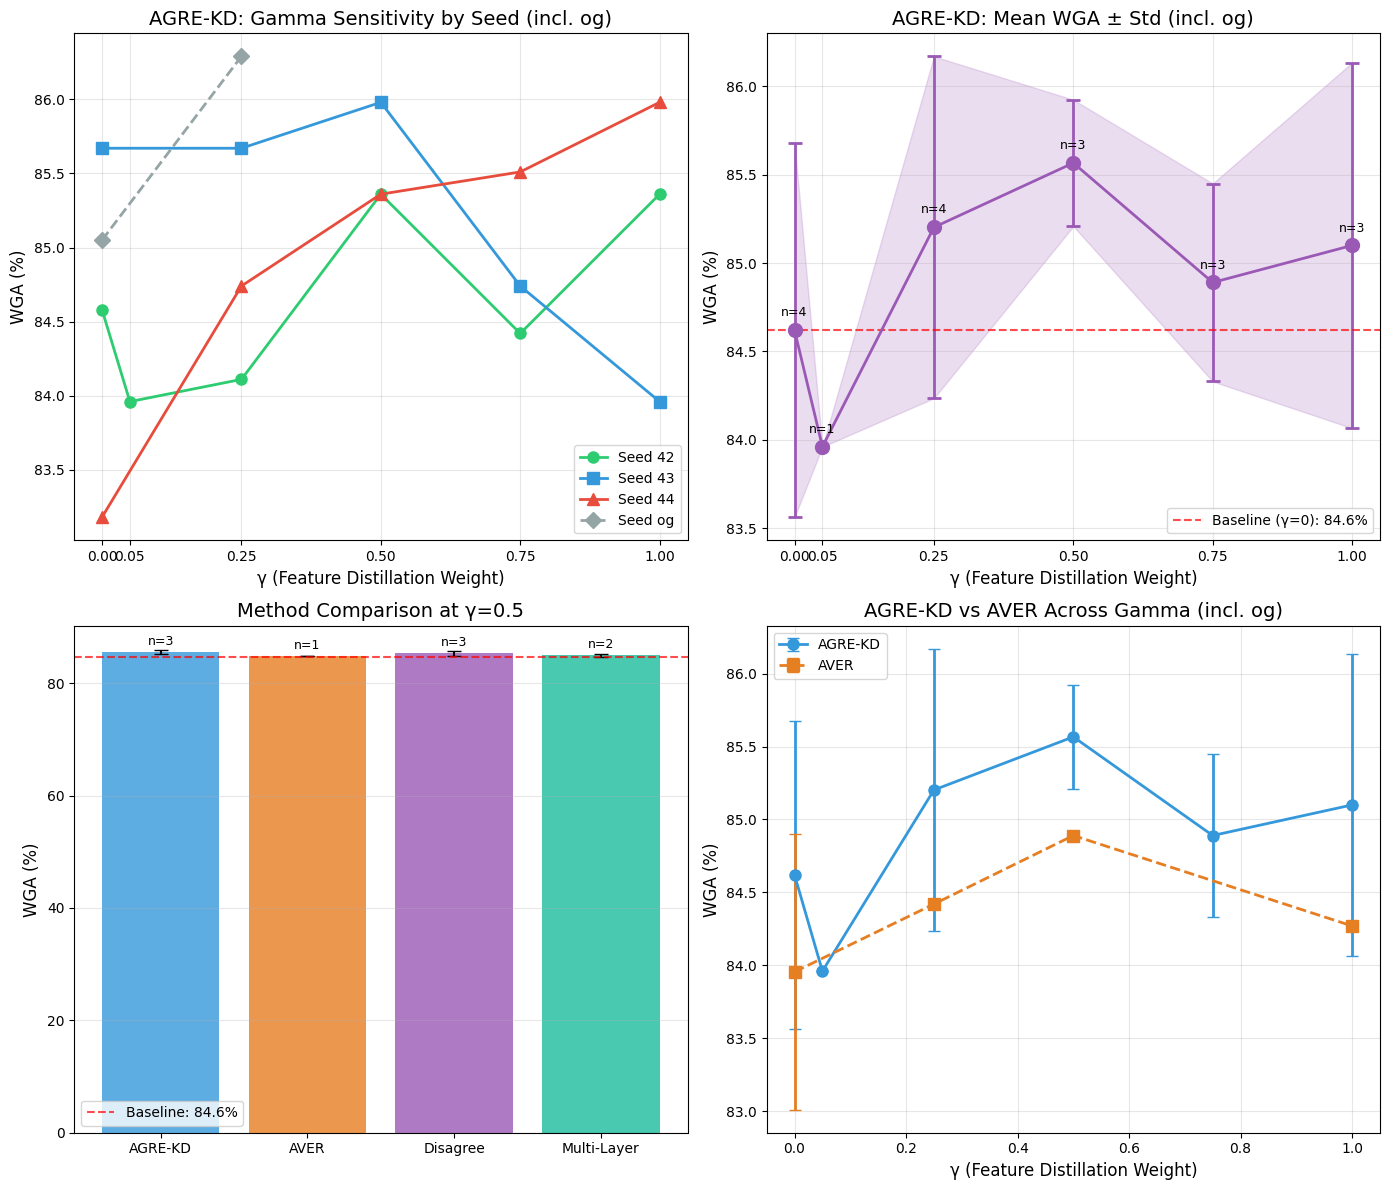


Saved: /content/drive/MyDrive/6.7960/robust-ensemble-kd/logs/complete_analysis.png

SEED VARIANCE ANALYSIS BY EXPERIMENT (INCLUDES 'og')

aver_baseline (AVER, γ=0.0):
  Seed og (og): 83.33%
  Seed 42: 84.42%
  Seed 43: 85.05%
  Seed 44: 83.02%
  → Mean: 83.95% | Std: 0.82% | Range: 2.03%

aver_gamma025 (AVER, γ=0.25):
  Seed 42: 84.42%

aver_gamma_050 (AVER, γ=0.5):
  Seed 42: 84.89%

aver_gamma_100 (AVER, γ=1.0):
  Seed 42: 84.27%

baseline_agrekd (AGRE-KD, γ=0.0):
  Seed og (og): 85.05%
  Seed 42: 84.58%
  Seed 43: 85.67%
  Seed 44: 83.18%
  → Mean: 84.62% | Std: 0.92% | Range: 2.49%

disagree_weight (Disagree-Weight, γ=0.5):
  Seed 42: 84.89%
  Seed 43: 85.67%
  Seed 44: 85.36%
  → Mean: 85.31% | Std: 0.32% | Range: 0.78%

exp2_gamma025 (AGRE-KD, γ=0.25):
  Seed og (og): 86.29%
  Seed 42: 84.11%
  Seed 43: 85.67%
  Seed 44: 84.74%
  → Mean: 85.20% | Std: 0.84% | Range: 2.18%

exp3_a09_g025 (AGRE-KD, γ=0.25):
  Seed 42: 83.18%
  Seed 43: 85.20%
  Seed 44: 84.11%
  → Mean: 84.16% | S

In [ ]:
# ============================================================
# Consolidated Results: All Experiments (Original + Seeded)
# INCLUDES 'og' (original unseeded) runs in all analyses
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Original results (no seed set - treat as additional data point)
ORIGINAL_RESULTS = {
    'baseline_agrekd': {'wga': 85.05, 'avg_acc': 91.42, 'alpha': 1.0, 'gamma': 0.0, 'use_agre': True},
    'exp2_gamma025': {'wga': 86.29, 'avg_acc': 92.96, 'alpha': 1.0, 'gamma': 0.25, 'use_agre': True},
    'aver_baseline': {'wga': 83.33, 'avg_acc': 92.79, 'alpha': 1.0, 'gamma': 0.0, 'use_agre': False},
}

# Load seeded results
log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')
with open(log_path, 'r') as f:
    seed_results = json.load(f)

# Build combined dataframe
rows = []

# Add original results
for base_exp, data in ORIGINAL_RESULTS.items():
    rows.append({
        'Experiment': base_exp,
        'Seed': 'og',
        'α': data['alpha'],
        'γ': data['gamma'],
        'Method': 'AGRE-KD' if data['use_agre'] else 'AVER',
        'WGA (%)': data['wga'],
        'Avg Acc (%)': data['avg_acc'],
    })

# Add seeded results with proper categorization
for exp_name, data in seed_results.items():
    base_exp = data.get('base_exp', exp_name.rsplit('_seed', 1)[0])

    # Determine experiment type from base_exp name
    is_aver = 'aver' in base_exp.lower()
    is_multilayer = base_exp.startswith('ml_')
    is_disagree = 'disagree' in base_exp.lower()

    # Get alpha (default 1.0, but exp3 uses 0.9)
    alpha = data.get('alpha', 1.0)

    # Determine method string
    if is_multilayer:
        method = 'Multi-Layer'
    elif is_disagree:
        method = 'Disagree-Weight'
    elif is_aver:
        method = 'AVER'
    else:
        method = 'AGRE-KD'

    rows.append({
        'Experiment': base_exp,
        'Seed': data.get('seed', 'N/A'),
        'α': alpha,
        'γ': data['gamma'],
        'Method': method,
        'WGA (%)': round(data['wga'] * 100, 2),
        'Avg Acc (%)': round(data.get('avg_acc', 0) * 100, 2),
    })

df = pd.DataFrame(rows)
# Convert all seeds to strings for consistent handling
df['Seed'] = df['Seed'].astype(str)

# Assign categories for organization
def get_category(row):
    if row['Method'] == 'Multi-Layer':
        return '6. Multi-Layer'
    if row['Method'] == 'Disagree-Weight':
        return '5. Disagree Weighting'
    if row['α'] < 1.0:
        return '4. Combined (α<1)'
    if row['Method'] == 'AVER':
        if row['γ'] == 0:
            return '1a. Baseline (AVER)'
        return '3. Feature Dist (AVER)'
    else:  # AGRE-KD
        if row['γ'] == 0:
            return '1b. Baseline (AGRE-KD)'
        return '2. Feature Dist (AGRE-KD)'

df['Category'] = df.apply(get_category, axis=1)

# Sort by category, then by experiment, then by seed
df_sorted = df.sort_values(['Category', 'Experiment', 'Seed'], ascending=[True, True, True])

# Display all runs
print("=" * 100)
print("ALL EXPERIMENT RUNS (organized by category) - INCLUDES 'og'")
print("=" * 100)
display_cols = ['Category', 'Experiment', 'Seed', 'α', 'γ', 'Method', 'WGA (%)', 'Avg Acc (%)']
print(df_sorted[display_cols].to_string(index=False))

# ============================================================
# AGGREGATED RESULTS - INCLUDES 'og' in calculations
# ============================================================
print("\n" + "=" * 100)
print("AGGREGATED RESULTS BY EXPERIMENT (INCLUDES 'og')")
print("=" * 100)

agg_rows = []
for base_exp in df['Experiment'].unique():
    subset = df[df['Experiment'] == base_exp]  # Include ALL runs including 'og'

    wga_mean = subset['WGA (%)'].mean()
    wga_std = subset['WGA (%)'].std() if len(subset) > 1 else 0
    avg_acc_mean = subset['Avg Acc (%)'].mean()
    n = len(subset)

    # Track which seeds we have
    seeds_list = sorted([str(s) for s in subset['Seed'].unique()])
    seeds_str = ','.join(seeds_list)

    method = subset['Method'].iloc[0]
    gamma = subset['γ'].iloc[0]
    alpha = subset['α'].iloc[0]
    category = subset['Category'].iloc[0]

    if wga_std > 0:
        wga_str = f"{wga_mean:.2f} ± {wga_std:.2f}"
    else:
        wga_str = f"{wga_mean:.2f}"

    agg_rows.append({
        'Category': category,
        'Experiment': base_exp,
        'Method': method,
        'α': alpha,
        'γ': gamma,
        'WGA (%)': wga_str,
        'Avg Acc (%)': f"{avg_acc_mean:.2f}",
        'n': n,
        'Seeds': seeds_str,
        '_wga_mean': wga_mean,
    })

agg_df = pd.DataFrame(agg_rows)

# Show two views: by category and by WGA
print("\n--- Grouped by Category ---")
agg_by_cat = agg_df.sort_values(['Category', '_wga_mean'], ascending=[True, False])
print(agg_by_cat[['Category', 'Experiment', 'Method', 'α', 'γ', 'WGA (%)', 'Avg Acc (%)', 'n',
'Seeds']].to_string(index=False))

# Add rank column for clarity
print("\n" + "-" * 100)
print("--- Ranked by WGA (INCLUDES 'og') ---")
agg_by_wga = agg_df.sort_values('_wga_mean', ascending=False).reset_index(drop=True)
agg_by_wga['Rank'] = range(1, len(agg_by_wga) + 1)
print(agg_by_wga[['Rank', 'Experiment', 'Method', 'α', 'γ', 'WGA (%)', 'Avg Acc (%)', 'n',
'Seeds']].to_string(index=False))

print("=" * 100)

# ============================================================
# KEY FINDINGS
# ============================================================
print("\n" + "=" * 100)
print("KEY FINDINGS")
print("=" * 100)

# Best overall
best = agg_df.loc[agg_df['_wga_mean'].idxmax()]
print(f"\n🏆 Best overall: {best['Experiment']} ({best['Method']}, α={best['α']}, γ={best['γ']})")
print(f"   WGA: {best['WGA (%)']}% (n={best['n']}, seeds: {best['Seeds']})")

# Best AGRE-KD (standard feature distillation)
agre_df = agg_df[(agg_df['Method'] == 'AGRE-KD') & (agg_df['γ'] > 0)]
if len(agre_df) > 0:
    best_agre = agre_df.loc[agre_df['_wga_mean'].idxmax()]
    print(f"\n📊 Best AGRE-KD Feature Dist: {best_agre['Experiment']} (γ={best_agre['γ']})")
    print(f"   WGA: {best_agre['WGA (%)']}% (n={best_agre['n']})")

# Baseline comparison
baseline = agg_df[agg_df['Experiment'] == 'baseline_agrekd']
if len(baseline) > 0:
    baseline_wga = baseline['_wga_mean'].iloc[0]
    print(f"\n📈 AGRE-KD Baseline (γ=0): {baseline_wga:.2f}%")

    # Best improvement
    if len(agre_df) > 0:
        best_improvement = agre_df['_wga_mean'].max() - baseline_wga
        print(f"   Best improvement: +{best_improvement:.2f}%")

# AVER vs AGRE-KD baseline comparison
aver_baseline = agg_df[agg_df['Experiment'] == 'aver_baseline']
if len(aver_baseline) > 0 and len(baseline) > 0:
    aver_wga = aver_baseline['_wga_mean'].iloc[0]
    agre_wga = baseline['_wga_mean'].iloc[0]
    diff = agre_wga - aver_wga
    print(f"\n🔄 AGRE-KD vs AVER Baseline:")
    print(f"   AGRE-KD: {agre_wga:.2f}% | AVER: {aver_wga:.2f}% | Diff: {diff:+.2f}%")

print("=" * 100)


# ============================================================
# GRAPHS: Gamma Sensitivity for AGRE-KD (INCLUDES 'og')
# ============================================================

# Filter to AGRE-KD with α=1.0 (the gamma ablation experiments) - INCLUDE 'og'
agrekd_gamma_exps = ['baseline_agrekd', 'gamma_005', 'exp2_gamma025', 'gamma_050', 'gamma_075', 'gamma_100']
gamma_df = df[df['Experiment'].isin(agrekd_gamma_exps)]  # Include 'og'

seeds = sorted([s for s in gamma_df['Seed'].unique()])
gammas = sorted(gamma_df['γ'].unique())

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

seed_colors = {'42': '#2ecc71', '43': '#3498db', '44': '#e74c3c', 'og': '#95a5a6'}
seed_markers = {'42': 'o', '43': 's', '44': '^', 'og': 'D'}

# --- Plot 1: AGRE-KD Gamma curves by seed (INCLUDES 'og') ---
ax1 = axes[0, 0]
for seed in seeds:
    seed_data = gamma_df[gamma_df['Seed'] == seed].sort_values('γ')
    if len(seed_data) > 0:
        linestyle = '--' if seed == 'og' else '-'
        ax1.plot(seed_data['γ'], seed_data['WGA (%)'],
                  marker=seed_markers.get(seed, 'o'), linewidth=2, markersize=8,
                  linestyle=linestyle,
                  label=f'Seed {seed}', color=seed_colors.get(seed, 'gray'))

ax1.set_xlabel('γ (Feature Distillation Weight)', fontsize=12)
ax1.set_ylabel('WGA (%)', fontsize=12)
ax1.set_title('AGRE-KD: Gamma Sensitivity by Seed (incl. og)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(gammas)

# --- Plot 2: Mean ± Std for AGRE-KD (INCLUDES 'og') ---
ax2 = axes[0, 1]
means, stds, ns = [], [], []
for g in gammas:
    g_data = gamma_df[gamma_df['γ'] == g]['WGA (%)']
    means.append(g_data.mean() if len(g_data) > 0 else 0)
    stds.append(g_data.std() if len(g_data) > 1 else 0)
    ns.append(len(g_data))

ax2.errorbar(gammas, means, yerr=stds, fmt='o-', linewidth=2,
              markersize=10, capsize=5, capthick=2, color='#9b59b6')
ax2.fill_between(gammas, np.array(means)-np.array(stds),
                  np.array(means)+np.array(stds), alpha=0.2, color='#9b59b6')

# Add n labels
for g, m, n in zip(gammas, means, ns):
    ax2.annotate(f'n={n}', (g, m), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9)

baseline_mean = gamma_df[gamma_df['γ'] == 0]['WGA (%)'].mean()
ax2.axhline(y=baseline_mean, color='red', linestyle='--',
            label=f'Baseline (γ=0): {baseline_mean:.1f}%', alpha=0.7)

ax2.set_xlabel('γ (Feature Distillation Weight)', fontsize=12)
ax2.set_ylabel('WGA (%)', fontsize=12)
ax2.set_title('AGRE-KD: Mean WGA ± Std (incl. og)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(gammas)

# --- Plot 3: Method Comparison (AGRE-KD vs AVER vs Disagree vs MultiLayer) ---
ax3 = axes[1, 0]

# Get experiments at γ=0.5 for comparison (common gamma across methods)
comparison_exps = {
    'AGRE-KD': 'gamma_050',
    'AVER': 'aver_gamma_050',
    'Disagree': 'disagree_weight',
    'Multi-Layer': ['ml_L3_L4', 'ml_L2_L3_L4'],
}

method_means = []
method_stds = []
method_labels = []
method_ns = []

for method_name, exp_names in comparison_exps.items():
    if isinstance(exp_names, list):
        subset = df[df['Experiment'].isin(exp_names)]  # Include 'og'
    else:
        subset = df[df['Experiment'] == exp_names]  # Include 'og'

    if len(subset) > 0:
        method_labels.append(method_name)
        method_means.append(subset['WGA (%)'].mean())
        method_stds.append(subset['WGA (%)'].std() if len(subset) > 1 else 0)
        method_ns.append(len(subset))

x = np.arange(len(method_labels))
colors = ['#3498db', '#e67e22', '#9b59b6', '#1abc9c']
bars = ax3.bar(x, method_means, yerr=method_stds, capsize=5, color=colors[:len(method_labels)], alpha=0.8)

# Add n labels on bars
for i, (bar, n) in enumerate(zip(bars, method_ns)):
    ax3.annotate(f'n={n}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                  textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9)

ax3.axhline(y=baseline_mean, color='red', linestyle='--', label=f'Baseline: {baseline_mean:.1f}%', alpha=0.7)
ax3.set_xticks(x)
ax3.set_xticklabels(method_labels)
ax3.set_ylabel('WGA (%)', fontsize=12)
ax3.set_title('Method Comparison at γ=0.5', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# --- Plot 4: AVER vs AGRE-KD across gammas (INCLUDES 'og') ---
ax4 = axes[1, 1]

# AGRE-KD line
ax4.errorbar(gammas, means, yerr=stds, fmt='o-', linewidth=2,
              markersize=8, capsize=4, color='#3498db', label='AGRE-KD')

# AVER points (include 'og')
aver_exps = ['aver_baseline', 'aver_gamma025', 'aver_gamma_050', 'aver_gamma_100']
aver_df_plot = df[df['Experiment'].isin(aver_exps)]  # Include 'og'
aver_gammas = sorted(aver_df_plot['γ'].unique())
aver_means = [aver_df_plot[aver_df_plot['γ'] == g]['WGA (%)'].mean() for g in aver_gammas]
aver_stds = [aver_df_plot[aver_df_plot['γ'] == g]['WGA (%)'].std() if len(aver_df_plot[aver_df_plot['γ'] == g]) > 1
else 0 for g in aver_gammas]

ax4.errorbar(aver_gammas, aver_means, yerr=aver_stds, fmt='s--', linewidth=2,
              markersize=8, capsize=4, color='#e67e22', label='AVER')

ax4.set_xlabel('γ (Feature Distillation Weight)', fontsize=12)
ax4.set_ylabel('WGA (%)', fontsize=12)
ax4.set_title('AGRE-KD vs AVER Across Gamma (incl. og)', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, 'complete_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {os.path.join(LOG_DIR, 'complete_analysis.png')}")


# ============================================================
# SEED VARIANCE ANALYSIS BY EXPERIMENT (INCLUDES 'og')
# ============================================================
print("\n" + "=" * 100)
print("SEED VARIANCE ANALYSIS BY EXPERIMENT (INCLUDES 'og')")
print("=" * 100)

for exp in sorted(df['Experiment'].unique()):
    subset = df[df['Experiment'] == exp]  # Include ALL including 'og'
    if len(subset) > 0:
        wgas = subset['WGA (%)'].values
        seeds_list = subset['Seed'].values
        gamma = subset['γ'].iloc[0]
        method = subset['Method'].iloc[0]

        print(f"\n{exp} ({method}, γ={gamma}):")
        for seed, wga in zip(seeds_list, wgas):
            marker = " (og)" if seed == 'og' else ""
            print(f"  Seed {seed}{marker}: {wga:.2f}%")
        if len(wgas) > 1:
            print(f"  → Mean: {np.mean(wgas):.2f}% | Std: {np.std(wgas):.2f}% | Range: {np.max(wgas)-np.min(wgas):.2f}%")

print("\n" + "=" * 100)

---
## 12. Teacher Disagreement Weighting Experiments

This experiment tests whether weighting feature dimensions by teacher agreement improves robustness.

**Concept**: Teachers trained on different seeds may learn different spurious features.
- Where teachers **agree** (low variance) → likely robust features → **high weight**
- Where teachers **disagree** (high variance) → likely spurious features → **low weight**

**Configuration**:
| Experiment | α | γ | Method | Description |
|------------|---|---|--------|-------------|
| disagree_weight_seed42 | 1.0 | 0.5 | AGRE-KD | Disagreement weighting on pooled features |
| disagree_weight_seed43 | 1.0 | 0.5 | AGRE-KD | Second seed (if time permits) |

**Baseline to beat**: `gamma_050_seed42` = 85.36% WGA

In [ ]:
# ============================================================
# Disagreement Weighting Experiment Runner
# ============================================================

def run_disagree_weight_experiment(exp_name, alpha, gamma, seed, use_agre=True):
    """
    Run a disagreement-weighted feature distillation experiment.

    Args:
        exp_name: Experiment name
        alpha: Weight for KD vs CE
        gamma: Weight for feature distillation
        seed: Random seed
        use_agre: If True, use AGRE-KD gradient-based weighting

    Returns:
        test_results: Dict with WGA, avg_acc, group_accs
    """
    full_exp_name = f"{exp_name}_seed{seed}"

    print(f"\n{'='*60}")
    print(f"DISAGREEMENT WEIGHTING EXPERIMENT: {full_exp_name}")
    print(f"  α={alpha}, γ={gamma}, AGRE={use_agre}, seed={seed}")
    print(f"  Feature weighting: dimension-wise teacher agreement")
    print(f"{'='*60}\n")

    # Check if already completed
    results_path = os.path.join(CHECKPOINT_DIR, f'student_{full_exp_name}_results.pt')
    if os.path.exists(results_path):
        print(f"Experiment already completed! Loading cached results...")
        results = torch.load(results_path)
        print_results(results['test_results'], f"{full_exp_name} (cached)")
        return results['test_results']

    # SET SEED
    set_seed(seed)

    # Check for resume checkpoint
    resume_path = os.path.join(CHECKPOINT_DIR, f'student_{full_exp_name}_latest.pt')
    if os.path.exists(resume_path):
        print(f"Found checkpoint, will resume training...")
    else:
        resume_path = None

    # Create config
    config = Config(
        data_dir=DATA_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        alpha=alpha,
        gamma=gamma,
        epochs=30,
        lr=0.001,
        batch_size=128,
        temperature=4.0,
        seed=seed,
    )

    # Train student with disagreement weighting
    student, history, test_results = train_student(
        config=config,
        teachers=teachers,
        biased_model=biased_model,
        exp_name=full_exp_name,
        use_agre=use_agre,
        checkpoint_path=resume_path,
        use_disagreement_weighting=True,  # NEW: Enable disagreement weighting
    )

    # Log results
    log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            all_logs = json.load(f)
    else:
        all_logs = {}

    all_logs[full_exp_name] = {
        'base_exp': exp_name,
        'seed': seed,
        'alpha': alpha,
        'gamma': gamma,
        'use_agre': use_agre,
        'use_disagreement_weighting': True,
        'wga': test_results['wga'],
        'avg_acc': test_results['avg_acc'],
        'group_accs': {str(k): v for k, v in test_results['group_accs'].items()},
    }

    with open(log_path, 'w') as f:
        json.dump(all_logs, f, indent=2)

    return test_results

print("Disagreement weighting experiment runner defined!")

Disagreement weighting experiment runner defined!


In [ ]:
# ============================================================
# Run Disagreement Weighting Experiments
# ============================================================

DISAGREE_EXPERIMENTS = [
    ('disagree_weight', 1.0, 0.5, True, 42),  # Primary experiment
    ('disagree_weight', 1.0, 0.5, True, 43),  # Uncomment if time permits
    ('disagree_weight', 1.0, 0.5, True, 44),  # Uncomment if time permits
]

disagree_results = {}

print("Starting Disagreement Weighting Experiments...")
print(f"Total runs: {len(DISAGREE_EXPERIMENTS)}\n")

for exp_name, alpha, gamma, use_agre, seed in DISAGREE_EXPERIMENTS:
    full_name = f"{exp_name}_seed{seed}"
    result = run_disagree_weight_experiment(exp_name, alpha, gamma, seed, use_agre)
    disagree_results[full_name] = result

print("\n" + "="*60)
print("DISAGREEMENT WEIGHTING EXPERIMENTS COMPLETE!")
print("="*60)

# Compare with baseline
print("\n" + "="*60)
print("COMPARISON: Disagreement Weighting vs Standard Feature Distillation")
print("="*60)

log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')
if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        all_results = json.load(f)

    comparisons = [
        ('gamma_050_seed42', 'Standard γ=0.5 (baseline)'),
        ('disagree_weight_seed42', 'Disagreement-weighted γ=0.5'),
    ]

    baseline_wga = None
    for key, label in comparisons:
        if key in all_results:
            wga = all_results[key]['wga'] * 100
            if baseline_wga is None:
                baseline_wga = wga
                delta = "—"
            else:
                delta = f"({wga - baseline_wga:+.2f}%)"
            print(f"{label}: {wga:.2f}% {delta}")
        else:
            print(f"{label}: N/A")

print("="*60)

Starting Disagreement Weighting Experiments...
Total runs: 2


DISAGREEMENT WEIGHTING EXPERIMENT: disagree_weight_seed42
  α=1.0, γ=0.5, AGRE=True, seed=42
  Feature weighting: dimension-wise teacher agreement

Experiment already completed! Loading cached results...

 disagree_weight_seed42 (cached)

Per-group accuracy:
  Landbird + Land (majority): 97.78% (n=2255)
  Landbird + Water (minority): 89.84% (n=2255)
  Waterbird + Land (minority, hardest): 84.89% (n=642)
  Waterbird + Water (majority): 92.52% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 84.89%
  Average Accuracy: 92.68%
  Accuracy Gap: 12.89%
  Worst Group: 2


DISAGREEMENT WEIGHTING EXPERIMENT: disagree_weight_seed43
  α=1.0, γ=0.5, AGRE=True, seed=43
  Feature weighting: dimension-wise teacher agreement

  Set random seed: 43

Training student: disagree_weight_seed43 (α=1.0, γ=0.5, method=AGRE-KD, disagree_weight=True)
Loaded train split: 4795 samples
  Group counts: {0: np.int64(3498), 1: np.int64(184), 2: np

Epoch 1/30: 100%|██████████| 37/37 [29:26<00:00, 47.75s/it, loss=1.6072]



Epoch 1/30
  Loss: total=2.5764, kd=2.3379
  Val WGA: 60.52% | Avg: 79.65%
  Groups: G0=95.5%, G1=60.5%, G2=72.9%, G3=97.7%
  Teacher weights: ['0.201', '0.183', '0.196', '0.200', '0.221']
  Time: 2277.7s | ETA: 1100.9min
  ✓ New best WGA: 60.52%


Epoch 2/30: 100%|██████████| 37/37 [02:37<00:00,  4.26s/it, loss=0.9866]



Epoch 2/30
  Loss: total=1.1784, kd=0.9729
  Val WGA: 69.92% | Avg: 89.49%
  Groups: G0=98.5%, G1=84.1%, G2=69.9%, G3=96.2%
  Teacher weights: ['0.208', '0.175', '0.202', '0.203', '0.211']
  Time: 167.4s | ETA: 78.1min
  ✓ New best WGA: 69.92%


Epoch 3/30: 100%|██████████| 37/37 [02:33<00:00,  4.15s/it, loss=0.9450]



Epoch 3/30
  Loss: total=0.9803, kd=0.7944
  Val WGA: 63.91% | Avg: 91.49%
  Groups: G0=98.9%, G1=91.4%, G2=63.9%, G3=93.2%
  Teacher weights: ['0.208', '0.180', '0.205', '0.196', '0.211']
  Time: 163.2s | ETA: 73.4min


Epoch 4/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.8421]



Epoch 4/30
  Loss: total=0.8548, kd=0.6833
  Val WGA: 73.68% | Avg: 90.66%
  Groups: G0=97.4%, G1=87.1%, G2=73.7%, G3=96.2%
  Teacher weights: ['0.205', '0.179', '0.204', '0.204', '0.208']
  Time: 162.4s | ETA: 70.4min
  ✓ New best WGA: 73.68%


Epoch 5/30: 100%|██████████| 37/37 [02:33<00:00,  4.15s/it, loss=0.7680]



Epoch 5/30
  Loss: total=0.7805, kd=0.6197
  Val WGA: 75.19% | Avg: 92.08%
  Groups: G0=98.1%, G1=89.7%, G2=75.2%, G3=96.2%
  Teacher weights: ['0.210', '0.178', '0.208', '0.197', '0.208']
  Time: 163.0s | ETA: 67.9min
  ✓ New best WGA: 75.19%


Epoch 6/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.7350]



Epoch 6/30
  Loss: total=0.7365, kd=0.5850
  Val WGA: 75.94% | Avg: 91.24%
  Groups: G0=97.4%, G1=87.8%, G2=75.9%, G3=97.0%
  Teacher weights: ['0.202', '0.173', '0.203', '0.212', '0.209']
  Time: 162.7s | ETA: 65.1min
  ✓ New best WGA: 75.94%


Epoch 7/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.6956]



Epoch 7/30
  Loss: total=0.7335, kd=0.5897
  Val WGA: 78.95% | Avg: 91.41%
  Groups: G0=97.0%, G1=87.8%, G2=78.9%, G3=97.0%
  Teacher weights: ['0.207', '0.177', '0.207', '0.206', '0.203']
  Time: 162.9s | ETA: 62.4min
  ✓ New best WGA: 78.95%


Epoch 8/30: 100%|██████████| 37/37 [02:33<00:00,  4.15s/it, loss=0.6274]



Epoch 8/30
  Loss: total=0.6598, kd=0.5222
  Val WGA: 78.95% | Avg: 92.16%
  Groups: G0=97.4%, G1=89.3%, G2=78.9%, G3=97.0%
  Teacher weights: ['0.209', '0.177', '0.204', '0.203', '0.206']
  Time: 163.2s | ETA: 59.8min


Epoch 9/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.6501]



Epoch 9/30
  Loss: total=0.6514, kd=0.5191
  Val WGA: 75.19% | Avg: 92.24%
  Groups: G0=97.6%, G1=90.6%, G2=75.2%, G3=96.2%
  Teacher weights: ['0.215', '0.178', '0.200', '0.203', '0.204']
  Time: 162.6s | ETA: 56.9min


Epoch 10/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5831]



Epoch 10/30
  Loss: total=0.6680, kd=0.5401
  Val WGA: 75.94% | Avg: 92.33%
  Groups: G0=97.6%, G1=91.0%, G2=75.9%, G3=94.7%
  Teacher weights: ['0.202', '0.183', '0.208', '0.207', '0.199']
  Time: 162.6s | ETA: 54.2min


Epoch 11/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.6862]



Epoch 11/30
  Loss: total=0.6370, kd=0.5131
  Val WGA: 75.19% | Avg: 92.58%
  Groups: G0=97.6%, G1=91.6%, G2=75.2%, G3=95.5%
  Teacher weights: ['0.204', '0.185', '0.207', '0.203', '0.201']
  Time: 162.9s | ETA: 51.6min


Epoch 12/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.5789]



Epoch 12/30
  Loss: total=0.6090, kd=0.4885
  Val WGA: 79.70% | Avg: 92.41%
  Groups: G0=97.0%, G1=89.9%, G2=79.7%, G3=97.7%
  Teacher weights: ['0.208', '0.177', '0.210', '0.197', '0.208']
  Time: 162.6s | ETA: 48.8min
  ✓ New best WGA: 79.70%


Epoch 13/30: 100%|██████████| 37/37 [02:33<00:00,  4.15s/it, loss=0.6250]



Epoch 13/30
  Loss: total=0.5956, kd=0.4776
  Val WGA: 80.45% | Avg: 92.83%
  Groups: G0=97.2%, G1=90.6%, G2=80.5%, G3=97.7%
  Teacher weights: ['0.208', '0.179', '0.205', '0.206', '0.202']
  Time: 162.6s | ETA: 46.1min
  ✓ New best WGA: 80.45%


Epoch 14/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5695]



Epoch 14/30
  Loss: total=0.5993, kd=0.4838
  Val WGA: 81.95% | Avg: 92.08%
  Groups: G0=97.2%, G1=88.0%, G2=82.0%, G3=98.5%
  Teacher weights: ['0.200', '0.179', '0.209', '0.201', '0.212']
  Time: 162.6s | ETA: 43.4min
  ✓ New best WGA: 81.95%


Epoch 15/30: 100%|██████████| 37/37 [02:33<00:00,  4.15s/it, loss=0.5573]



Epoch 15/30
  Loss: total=0.5931, kd=0.4796
  Val WGA: 75.19% | Avg: 92.83%
  Groups: G0=98.3%, G1=91.4%, G2=75.2%, G3=96.2%
  Teacher weights: ['0.195', '0.176', '0.212', '0.203', '0.214']
  Time: 162.4s | ETA: 40.6min


Epoch 16/30: 100%|██████████| 37/37 [02:33<00:00,  4.15s/it, loss=0.6269]



Epoch 16/30
  Loss: total=0.5741, kd=0.4621
  Val WGA: 75.19% | Avg: 92.91%
  Groups: G0=98.1%, G1=91.8%, G2=75.2%, G3=96.2%
  Teacher weights: ['0.203', '0.178', '0.209', '0.205', '0.205']
  Time: 162.4s | ETA: 37.9min


Epoch 17/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5359]



Epoch 17/30
  Loss: total=0.5566, kd=0.4468
  Val WGA: 78.95% | Avg: 92.91%
  Groups: G0=97.4%, G1=91.0%, G2=78.9%, G3=97.7%
  Teacher weights: ['0.206', '0.175', '0.203', '0.206', '0.210']
  Time: 162.3s | ETA: 35.2min


Epoch 18/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.5935]



Epoch 18/30
  Loss: total=0.5520, kd=0.4436
  Val WGA: 81.20% | Avg: 92.49%
  Groups: G0=97.0%, G1=89.7%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.210', '0.171', '0.212', '0.205', '0.201']
  Time: 162.0s | ETA: 32.4min


Epoch 19/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5213]



Epoch 19/30
  Loss: total=0.5631, kd=0.4551
  Val WGA: 81.20% | Avg: 92.99%
  Groups: G0=97.0%, G1=91.0%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.205', '0.176', '0.208', '0.204', '0.207']
  Time: 162.2s | ETA: 29.7min


Epoch 20/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5331]



Epoch 20/30
  Loss: total=0.5425, kd=0.4365
  Val WGA: 79.70% | Avg: 92.91%
  Groups: G0=97.2%, G1=91.0%, G2=79.7%, G3=97.7%
  Teacher weights: ['0.213', '0.179', '0.205', '0.195', '0.207']
  Time: 162.5s | ETA: 27.1min


Epoch 21/30: 100%|██████████| 37/37 [02:33<00:00,  4.16s/it, loss=0.4779]



Epoch 21/30
  Loss: total=0.5380, kd=0.4320
  Val WGA: 78.20% | Avg: 92.91%
  Groups: G0=97.4%, G1=91.4%, G2=78.2%, G3=97.0%
  Teacher weights: ['0.208', '0.180', '0.209', '0.197', '0.206']
  Time: 162.8s | ETA: 24.4min


Epoch 22/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5711]



Epoch 22/30
  Loss: total=0.5482, kd=0.4433
  Val WGA: 80.45% | Avg: 93.08%
  Groups: G0=97.2%, G1=91.4%, G2=80.5%, G3=97.0%
  Teacher weights: ['0.205', '0.174', '0.213', '0.197', '0.212']
  Time: 162.3s | ETA: 21.6min


Epoch 23/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.5925]



Epoch 23/30
  Loss: total=0.5307, kd=0.4261
  Val WGA: 81.20% | Avg: 92.66%
  Groups: G0=97.0%, G1=90.1%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.212', '0.174', '0.207', '0.203', '0.205']
  Time: 162.0s | ETA: 18.9min


Epoch 24/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.5818]



Epoch 24/30
  Loss: total=0.5338, kd=0.4300
  Val WGA: 81.20% | Avg: 92.74%
  Groups: G0=97.0%, G1=90.3%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.205', '0.177', '0.208', '0.204', '0.206']
  Time: 162.1s | ETA: 16.2min


Epoch 25/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5960]



Epoch 25/30
  Loss: total=0.5395, kd=0.4362
  Val WGA: 81.20% | Avg: 92.74%
  Groups: G0=97.0%, G1=90.3%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.199', '0.171', '0.214', '0.211', '0.205']
  Time: 161.9s | ETA: 13.5min


Epoch 26/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5953]



Epoch 26/30
  Loss: total=0.5320, kd=0.4279
  Val WGA: 81.20% | Avg: 93.33%
  Groups: G0=97.4%, G1=91.4%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.207', '0.176', '0.211', '0.202', '0.204']
  Time: 161.7s | ETA: 10.8min


Epoch 27/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.5561]



Epoch 27/30
  Loss: total=0.5396, kd=0.4362
  Val WGA: 81.20% | Avg: 93.24%
  Groups: G0=97.2%, G1=91.4%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.210', '0.173', '0.207', '0.203', '0.207']
  Time: 161.5s | ETA: 8.1min


Epoch 28/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.6673]



Epoch 28/30
  Loss: total=0.5364, kd=0.4327
  Val WGA: 81.20% | Avg: 92.91%
  Groups: G0=97.0%, G1=90.8%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.201', '0.182', '0.207', '0.207', '0.203']
  Time: 161.7s | ETA: 5.4min


Epoch 29/30: 100%|██████████| 37/37 [02:33<00:00,  4.14s/it, loss=0.5861]



Epoch 29/30
  Loss: total=0.5162, kd=0.4126
  Val WGA: 81.20% | Avg: 93.16%
  Groups: G0=97.2%, G1=91.2%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.206', '0.175', '0.210', '0.203', '0.206']
  Time: 161.6s | ETA: 2.7min


Epoch 30/30: 100%|██████████| 37/37 [02:32<00:00,  4.13s/it, loss=0.4917]



Epoch 30/30
  Loss: total=0.5209, kd=0.4175
  Val WGA: 81.20% | Avg: 92.91%
  Groups: G0=97.0%, G1=90.8%, G2=81.2%, G3=97.7%
  Teacher weights: ['0.207', '0.181', '0.208', '0.204', '0.200']
  Time: 161.8s | ETA: 0.0min

Loading best checkpoint for final evaluation...
  Loaded from epoch 14 with val WGA: 81.95%

Final Test Evaluation (disagree_weight_seed43):
  Evaluating 5794 samples (46 batches)...


KeyboardInterrupt: 

---
## 13. Additional Seeding Tests

Overnight experiments to get 3-seed statistical significance on the gamma sensitivity curve.

| Computer | Experiments | Runs | Time |
|----------|-------------|------|------|
| **Computer 1** | γ=0.5 (43, 44) + baseline (44) + γ=0.75 (43) | 4 | ~4 hrs |
| **Computer 2** | γ=1.0 (43, 44) + γ=0.75 (44) + γ=0.25 (44) | 4 | ~4 hrs |

**Priority order**: γ=0.5, γ=1.0, baseline first, then γ=0.75, γ=0.25

**Goal**: Complete gamma sensitivity curve with proper 3-seed statistics.


In [ ]:
# ============================================================
# COMPUTER 1: γ=0.5 + Baseline + γ=0.75
# Priority: γ=0.5 and baseline first, then γ=0.75
# ============================================================

COMPUTER_1_EXPERIMENTS = [
    # Priority 1: γ=0.5 (best performing)
    ('gamma_050', 1.0, 0.50, True, 43),
    ('gamma_050', 1.0, 0.50, True, 44),
    # Priority 2: Baseline with proper seed
    ('baseline_agrekd', 1.0, 0.00, True, 44),
    # Priority 3: γ=0.75 to complete curve
    ('gamma_075', 1.0, 0.75, True, 43),
    # third test for aver baseline
    ('aver_baseline', 1.0, 0.0, False, 44),
]

print("=" * 60)
print("COMPUTER 1: Overnight Seeding Experiments")
print("=" * 60)
print(f"Total runs: {len(COMPUTER_1_EXPERIMENTS)}")
print("Priority: γ=0.5 → baseline → γ=0.75")
print("=" * 60)

for exp_name, alpha, gamma, use_agre, seed in COMPUTER_1_EXPERIMENTS:
    full_name = f"{exp_name}_seed{seed}"

    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {full_name}")
    print(f"  α={alpha}, γ={gamma}, AGRE={use_agre}, seed={seed}")
    print(f"{'='*60}\n")

    # Check if already done
    results_path = os.path.join(CHECKPOINT_DIR, f'student_{full_name}_results.pt')
    if os.path.exists(results_path):
        print(f"Already completed! Loading cached results...")
        results = torch.load(results_path)
        print_results(results['test_results'], f"{full_name} (cached)")
        continue

    set_seed(seed)

    config = Config(
        data_dir=DATA_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        alpha=alpha,
        gamma=gamma,
        epochs=30,
        lr=0.001,
        batch_size=128,
        temperature=4.0,
        seed=seed,
    )

    resume_path = os.path.join(CHECKPOINT_DIR, f'student_{full_name}_latest.pt')
    if not os.path.exists(resume_path):
        resume_path = None

    student, history, test_results = train_student(
        config=config,
        teachers=teachers,
        biased_model=biased_model,
        exp_name=full_name,
        use_agre=use_agre,
        checkpoint_path=resume_path,
    )

    # Log results
    log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            all_logs = json.load(f)
    else:
        all_logs = {}

    all_logs[full_name] = {
        'base_exp': exp_name,
        'seed': seed,
        'alpha': alpha,
        'gamma': gamma,
        'use_agre': use_agre,
        'wga': test_results['wga'],
        'avg_acc': test_results['avg_acc'],
        'group_accs': {str(k): v for k, v in test_results['group_accs'].items()},
    }

    with open(log_path, 'w') as f:
        json.dump(all_logs, f, indent=2)

print("\n" + "=" * 60)
print("COMPUTER 1 COMPLETE!")
print("=" * 60)


COMPUTER 1: Overnight Seeding Experiments
Total runs: 5
Priority: γ=0.5 → baseline → γ=0.75

EXPERIMENT: gamma_050_seed43
  α=1.0, γ=0.5, AGRE=True, seed=43

Already completed! Loading cached results...

 gamma_050_seed43 (cached)

Per-group accuracy:
  Landbird + Land (majority): 97.65% (n=2255)
  Landbird + Water (minority): 88.51% (n=2255)
  Waterbird + Land (minority, hardest): 85.98% (n=642)
  Waterbird + Water (majority): 94.08% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 85.98%
  Average Accuracy: 92.41%
  Accuracy Gap: 11.67%
  Worst Group: 2


EXPERIMENT: gamma_050_seed44
  α=1.0, γ=0.5, AGRE=True, seed=44

Already completed! Loading cached results...

 gamma_050_seed44 (cached)

Per-group accuracy:
  Landbird + Land (majority): 97.21% (n=2255)
  Landbird + Water (minority): 86.56% (n=2255)
  Waterbird + Land (minority, hardest): 85.36% (n=642)
  Waterbird + Water (majority): 93.15% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 85.36%
  Average Accura

Epoch 1/30: 100%|██████████| 37/37 [01:17<00:00,  2.09s/it, loss=1.2125]



Epoch 1/30
  Loss: total=2.2261, kd=2.2261
  Val WGA: 54.14% | Avg: 80.23%
  Groups: G0=97.9%, G1=65.2%, G2=54.1%, G3=97.0%
  Time: 86.2s | ETA: 41.7min
  ✓ New best WGA: 54.14%


Epoch 2/30: 100%|██████████| 37/37 [01:24<00:00,  2.30s/it, loss=1.0173]



Epoch 2/30
  Loss: total=1.0127, kd=1.0127
  Val WGA: 58.65% | Avg: 89.82%
  Groups: G0=98.7%, G1=88.4%, G2=58.6%, G3=94.7%
  Time: 95.0s | ETA: 44.3min
  ✓ New best WGA: 58.65%


Epoch 3/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.7986]



Epoch 3/30
  Loss: total=0.7757, kd=0.7757
  Val WGA: 67.67% | Avg: 89.99%
  Groups: G0=97.9%, G1=87.1%, G2=67.7%, G3=94.7%
  Time: 94.5s | ETA: 42.5min
  ✓ New best WGA: 67.67%


Epoch 4/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.7019]



Epoch 4/30
  Loss: total=0.7236, kd=0.7236
  Val WGA: 70.68% | Avg: 90.24%
  Groups: G0=97.9%, G1=86.3%, G2=70.7%, G3=97.0%
  Time: 93.7s | ETA: 40.6min
  ✓ New best WGA: 70.68%


Epoch 5/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.6510]



Epoch 5/30
  Loss: total=0.6270, kd=0.6270
  Val WGA: 73.68% | Avg: 90.83%
  Groups: G0=97.9%, G1=87.3%, G2=73.7%, G3=95.5%
  Time: 92.9s | ETA: 38.7min
  ✓ New best WGA: 73.68%


Epoch 6/30: 100%|██████████| 37/37 [01:24<00:00,  2.29s/it, loss=0.4225]



Epoch 6/30
  Loss: total=0.5855, kd=0.5855
  Val WGA: 77.44% | Avg: 91.41%
  Groups: G0=97.6%, G1=87.6%, G2=77.4%, G3=97.0%
  Time: 94.5s | ETA: 37.8min
  ✓ New best WGA: 77.44%


Epoch 7/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.5981]



Epoch 7/30
  Loss: total=0.5656, kd=0.5656
  Val WGA: 77.44% | Avg: 91.24%
  Groups: G0=97.6%, G1=87.3%, G2=77.4%, G3=96.2%
  Time: 93.9s | ETA: 36.0min


Epoch 8/30: 100%|██████████| 37/37 [01:24<00:00,  2.27s/it, loss=0.5901]



Epoch 8/30
  Loss: total=0.5480, kd=0.5480
  Val WGA: 69.17% | Avg: 92.33%
  Groups: G0=98.7%, G1=91.8%, G2=69.2%, G3=94.7%
  Time: 93.6s | ETA: 34.3min


Epoch 9/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.5201]



Epoch 9/30
  Loss: total=0.5212, kd=0.5212
  Val WGA: 79.70% | Avg: 91.49%
  Groups: G0=97.6%, G1=86.7%, G2=79.7%, G3=98.5%
  Time: 92.8s | ETA: 32.5min
  ✓ New best WGA: 79.70%


Epoch 10/30: 100%|██████████| 37/37 [01:25<00:00,  2.30s/it, loss=0.5746]



Epoch 10/30
  Loss: total=0.5144, kd=0.5144
  Val WGA: 78.95% | Avg: 92.33%
  Groups: G0=97.9%, G1=89.3%, G2=78.9%, G3=97.0%
  Time: 94.8s | ETA: 31.6min


Epoch 11/30: 100%|██████████| 37/37 [01:24<00:00,  2.29s/it, loss=0.3919]



Epoch 11/30
  Loss: total=0.5092, kd=0.5092
  Val WGA: 73.68% | Avg: 91.83%
  Groups: G0=98.1%, G1=89.5%, G2=73.7%, G3=96.2%
  Time: 94.5s | ETA: 29.9min


Epoch 12/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.4037]



Epoch 12/30
  Loss: total=0.4968, kd=0.4968
  Val WGA: 81.20% | Avg: 92.41%
  Groups: G0=97.4%, G1=89.1%, G2=81.2%, G3=97.7%
  Time: 93.6s | ETA: 28.1min
  ✓ New best WGA: 81.20%


Epoch 13/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.3905]



Epoch 13/30
  Loss: total=0.5190, kd=0.5190
  Val WGA: 77.44% | Avg: 92.08%
  Groups: G0=97.6%, G1=89.3%, G2=77.4%, G3=97.0%
  Time: 92.7s | ETA: 26.3min


Epoch 14/30: 100%|██████████| 37/37 [01:24<00:00,  2.29s/it, loss=0.4027]



Epoch 14/30
  Loss: total=0.4701, kd=0.4701
  Val WGA: 81.20% | Avg: 92.24%
  Groups: G0=97.4%, G1=88.4%, G2=81.2%, G3=98.5%
  Time: 94.8s | ETA: 25.3min


Epoch 15/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.4794]



Epoch 15/30
  Loss: total=0.4576, kd=0.4576
  Val WGA: 78.95% | Avg: 92.58%
  Groups: G0=97.9%, G1=89.9%, G2=78.9%, G3=97.0%
  Time: 94.2s | ETA: 23.6min


Epoch 16/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.4281]



Epoch 16/30
  Loss: total=0.4566, kd=0.4566
  Val WGA: 79.70% | Avg: 92.49%
  Groups: G0=97.6%, G1=89.5%, G2=79.7%, G3=97.7%
  Time: 94.2s | ETA: 22.0min


Epoch 17/30: 100%|██████████| 37/37 [01:23<00:00,  2.27s/it, loss=0.5226]



Epoch 17/30
  Loss: total=0.4537, kd=0.4537
  Val WGA: 80.45% | Avg: 92.49%
  Groups: G0=97.4%, G1=89.3%, G2=80.5%, G3=98.5%
  Time: 92.7s | ETA: 20.1min


Epoch 18/30: 100%|██████████| 37/37 [01:25<00:00,  2.31s/it, loss=0.4528]



Epoch 18/30
  Loss: total=0.4426, kd=0.4426
  Val WGA: 79.70% | Avg: 92.66%
  Groups: G0=97.6%, G1=90.1%, G2=79.7%, G3=97.0%
  Time: 94.2s | ETA: 18.8min


Epoch 19/30: 100%|██████████| 37/37 [01:23<00:00,  2.27s/it, loss=0.4614]



Epoch 19/30
  Loss: total=0.4397, kd=0.4397
  Val WGA: 79.70% | Avg: 92.58%
  Groups: G0=97.6%, G1=89.7%, G2=79.7%, G3=97.7%
  Time: 93.9s | ETA: 17.2min


Epoch 20/30: 100%|██████████| 37/37 [01:24<00:00,  2.27s/it, loss=0.5643]



Epoch 20/30
  Loss: total=0.4282, kd=0.4282
  Val WGA: 79.70% | Avg: 92.99%
  Groups: G0=97.9%, G1=90.6%, G2=79.7%, G3=97.7%
  Time: 93.8s | ETA: 15.6min


Epoch 21/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.3408]



Epoch 21/30
  Loss: total=0.4177, kd=0.4177
  Val WGA: 79.70% | Avg: 92.58%
  Groups: G0=97.4%, G1=89.9%, G2=79.7%, G3=97.7%
  Time: 93.4s | ETA: 14.0min


Epoch 22/30: 100%|██████████| 37/37 [01:24<00:00,  2.29s/it, loss=0.4045]



Epoch 22/30
  Loss: total=0.4308, kd=0.4308
  Val WGA: 80.45% | Avg: 92.16%
  Groups: G0=97.4%, G1=88.4%, G2=80.5%, G3=98.5%
  Time: 93.3s | ETA: 12.4min


Epoch 23/30: 100%|██████████| 37/37 [01:24<00:00,  2.27s/it, loss=0.3542]



Epoch 23/30
  Loss: total=0.4354, kd=0.4354
  Val WGA: 80.45% | Avg: 92.58%
  Groups: G0=97.4%, G1=89.5%, G2=80.5%, G3=98.5%
  Time: 94.0s | ETA: 11.0min


Epoch 24/30: 100%|██████████| 37/37 [01:23<00:00,  2.27s/it, loss=0.4561]



Epoch 24/30
  Loss: total=0.4333, kd=0.4333
  Val WGA: 80.45% | Avg: 92.49%
  Groups: G0=97.2%, G1=89.5%, G2=80.5%, G3=98.5%
  Time: 93.7s | ETA: 9.4min


Epoch 25/30: 100%|██████████| 37/37 [01:24<00:00,  2.27s/it, loss=0.4529]



Epoch 25/30
  Loss: total=0.4272, kd=0.4272
  Val WGA: 79.70% | Avg: 92.66%
  Groups: G0=97.6%, G1=89.7%, G2=79.7%, G3=98.5%
  Time: 92.6s | ETA: 7.7min


Epoch 26/30: 100%|██████████| 37/37 [01:25<00:00,  2.31s/it, loss=0.3894]



Epoch 26/30
  Loss: total=0.4224, kd=0.4224
  Val WGA: 80.45% | Avg: 92.74%
  Groups: G0=97.6%, G1=89.7%, G2=80.5%, G3=98.5%
  Time: 94.7s | ETA: 6.3min


Epoch 27/30: 100%|██████████| 37/37 [01:24<00:00,  2.27s/it, loss=0.4025]



Epoch 27/30
  Loss: total=0.4166, kd=0.4166
  Val WGA: 80.45% | Avg: 92.66%
  Groups: G0=97.6%, G1=89.7%, G2=80.5%, G3=97.7%
  Time: 94.0s | ETA: 4.7min


Epoch 28/30: 100%|██████████| 37/37 [01:24<00:00,  2.27s/it, loss=0.4056]



Epoch 28/30
  Loss: total=0.4089, kd=0.4089
  Val WGA: 80.45% | Avg: 92.66%
  Groups: G0=97.6%, G1=89.7%, G2=80.5%, G3=97.7%
  Time: 93.7s | ETA: 3.1min


Epoch 29/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.5190]



Epoch 29/30
  Loss: total=0.4339, kd=0.4339
  Val WGA: 80.45% | Avg: 92.66%
  Groups: G0=97.6%, G1=89.7%, G2=80.5%, G3=97.7%
  Time: 92.9s | ETA: 1.5min


Epoch 30/30: 100%|██████████| 37/37 [01:24<00:00,  2.28s/it, loss=0.3734]



Epoch 30/30
  Loss: total=0.4300, kd=0.4300
  Val WGA: 80.45% | Avg: 92.58%
  Groups: G0=97.4%, G1=89.7%, G2=80.5%, G3=97.7%
  Time: 94.2s | ETA: 0.0min

Loading best checkpoint for final evaluation...
  Loaded from epoch 12 with val WGA: 81.20%

Final Test Evaluation (aver_baseline_seed44):
  Evaluating 5794 samples (46 batches)...


  Evaluation complete (2045.7s) - WGA: 83.0%

 Student Test Results (aver_baseline_seed44)

Per-group accuracy:
  Landbird + Land (majority): 97.96% (n=2255)
  Landbird + Water (minority): 89.53% (n=2255)
  Waterbird + Land (minority, hardest): 83.02% (n=642)
  Waterbird + Water (majority): 93.30% (n=642)

Aggregate metrics:
  Worst-Group Accuracy (WGA): 83.02%
  Average Accuracy: 92.51%
  Accuracy Gap: 14.94%
  Worst Group: 2


COMPUTER 1 COMPLETE!


In [ ]:
# ============================================================
# COMPUTER 2: γ=1.0 + γ=0.75 + γ=0.25
# Priority: γ=1.0 first, then γ=0.75, then γ=0.25
# ============================================================

COMPUTER_2_EXPERIMENTS = [
    # Priority 1: γ=1.0 (tied for best)
    ('gamma_100', 1.0, 1.00, True, 43),
    ('gamma_100', 1.0, 1.00, True, 44),
    # Priority 2: γ=0.75 to complete curve
    ('gamma_075', 1.0, 0.75, True, 44),
    # Priority 3: γ=0.25 to replace unseeded "og"
    ('exp2_gamma025', 1.0, 0.25, True, 44),
]

print("=" * 60)
print("COMPUTER 2: Overnight Seeding Experiments")
print("=" * 60)
print(f"Total runs: {len(COMPUTER_2_EXPERIMENTS)}")
print("Priority: γ=1.0 → γ=0.75 → γ=0.25")
print("=" * 60)

for exp_name, alpha, gamma, use_agre, seed in COMPUTER_2_EXPERIMENTS:
    full_name = f"{exp_name}_seed{seed}"

    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {full_name}")
    print(f"  α={alpha}, γ={gamma}, AGRE={use_agre}, seed={seed}")
    print(f"{'='*60}\n")

    # Check if already done
    results_path = os.path.join(CHECKPOINT_DIR, f'student_{full_name}_results.pt')
    if os.path.exists(results_path):
        print(f"Already completed! Loading cached results...")
        results = torch.load(results_path)
        print_results(results['test_results'], f"{full_name} (cached)")
        continue

    set_seed(seed)

    config = Config(
        data_dir=DATA_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        alpha=alpha,
        gamma=gamma,
        epochs=30,
        lr=0.001,
        batch_size=128,
        temperature=4.0,
        seed=seed,
    )

    resume_path = os.path.join(CHECKPOINT_DIR, f'student_{full_name}_latest.pt')
    if not os.path.exists(resume_path):
        resume_path = None

    student, history, test_results = train_student(
        config=config,
        teachers=teachers,
        biased_model=biased_model,
        exp_name=full_name,
        use_agre=use_agre,
        checkpoint_path=resume_path,
    )

    # Log results
    log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            all_logs = json.load(f)
    else:
        all_logs = {}

    all_logs[full_name] = {
        'base_exp': exp_name,
        'seed': seed,
        'alpha': alpha,
        'gamma': gamma,
        'use_agre': use_agre,
        'wga': test_results['wga'],
        'avg_acc': test_results['avg_acc'],
        'group_accs': {str(k): v for k, v in test_results['group_accs'].items()},
    }

    with open(log_path, 'w') as f:
        json.dump(all_logs, f, indent=2)

print("\n" + "=" * 60)
print("COMPUTER 2 COMPLETE!")
print("=" * 60)


In [ ]:
# ============================================================
# Complete Gamma Curve Results Summary
# ============================================================
import numpy as np

print("=" * 70)
print("COMPLETE GAMMA SENSITIVITY CURVE RESULTS")
print("=" * 70)

log_path = os.path.join(LOG_DIR, 'seed_experiment_results.json')
with open(log_path, 'r') as f:
    all_results = json.load(f)

# Helper function
def get_stats(exp_prefix, seeds=[42, 43, 44]):
    wgas = []
    for seed in seeds:
        key = f"{exp_prefix}_seed{seed}"
        if key in all_results:
            wgas.append(all_results[key]['wga'] * 100)
    return wgas

# Baseline (γ=0)
print("\nBaseline AGRE-KD (γ=0):")
baseline_wgas = get_stats('baseline_agrekd')
for i, seed in enumerate([42, 43, 44]):
    if i < len(baseline_wgas):
        print(f"  Seed {seed}: {baseline_wgas[i]:.2f}%")
if len(baseline_wgas) >= 2:
    print(f"  Mean ± Std: {np.mean(baseline_wgas):.2f} ± {np.std(baseline_wgas):.2f}% (n={len(baseline_wgas)})")

# γ=0.25
print("\nγ=0.25 (AGRE-KD):")
gamma_025_wgas = get_stats('exp2_gamma025')
for i, seed in enumerate([42, 43, 44]):
    if i < len(gamma_025_wgas):
        print(f"  Seed {seed}: {gamma_025_wgas[i]:.2f}%")
if len(gamma_025_wgas) >= 2:
    print(f"  Mean ± Std: {np.mean(gamma_025_wgas):.2f} ± {np.std(gamma_025_wgas):.2f}% (n={len(gamma_025_wgas)})")

# γ=0.5
print("\nγ=0.5 (AGRE-KD):")
gamma_05_wgas = get_stats('gamma_050')
for i, seed in enumerate([42, 43, 44]):
    if i < len(gamma_05_wgas):
        print(f"  Seed {seed}: {gamma_05_wgas[i]:.2f}%")
if len(gamma_05_wgas) >= 2:
    print(f"  Mean ± Std: {np.mean(gamma_05_wgas):.2f} ± {np.std(gamma_05_wgas):.2f}% (n={len(gamma_05_wgas)})")

# γ=0.75
print("\nγ=0.75 (AGRE-KD):")
gamma_075_wgas = get_stats('gamma_075')
for i, seed in enumerate([42, 43, 44]):
    if i < len(gamma_075_wgas):
        print(f"  Seed {seed}: {gamma_075_wgas[i]:.2f}%")
if len(gamma_075_wgas) >= 2:
    print(f"  Mean ± Std: {np.mean(gamma_075_wgas):.2f} ± {np.std(gamma_075_wgas):.2f}% (n={len(gamma_075_wgas)})")

# γ=1.0
print("\nγ=1.0 (AGRE-KD):")
gamma_10_wgas = get_stats('gamma_100')
for i, seed in enumerate([42, 43, 44]):
    if i < len(gamma_10_wgas):
        print(f"  Seed {seed}: {gamma_10_wgas[i]:.2f}%")
if len(gamma_10_wgas) >= 2:
    print(f"  Mean ± Std: {np.mean(gamma_10_wgas):.2f} ± {np.std(gamma_10_wgas):.2f}% (n={len(gamma_10_wgas)})")

# Summary table
print("\n" + "=" * 70)
print("GAMMA SENSITIVITY SUMMARY")
print("=" * 70)
print(f"{'γ':<8} {'Mean WGA':<12} {'Std':<8} {'n':<4} {'Δ vs Baseline':<15}")
print("-" * 50)

all_gamma_results = [
    (0.00, baseline_wgas, 'baseline'),
    (0.25, gamma_025_wgas, 'γ=0.25'),
    (0.50, gamma_05_wgas, 'γ=0.50'),
    (0.75, gamma_075_wgas, 'γ=0.75'),
    (1.00, gamma_10_wgas, 'γ=1.00'),
]

baseline_mean = np.mean(baseline_wgas) if baseline_wgas else 0

for gamma, wgas, label in all_gamma_results:
    if wgas:
        mean = np.mean(wgas)
        std = np.std(wgas) if len(wgas) > 1 else 0
        delta = mean - baseline_mean if gamma > 0 else 0
        delta_str = f"{delta:+.2f}%" if gamma > 0 else "—"
        print(f"{gamma:<8.2f} {mean:<12.2f} {std:<8.2f} {len(wgas):<4} {delta_str:<15}")

print("=" * 70)
